## Table of contents:

  * <a href=#Reading>1 Reading in the data</a>
  * <a href=#Preprocessing>2 Pre-processing and visualization</a>
    * <a href=#QC>2.1 Quality Control</a>
    * <a href=#Normalization>2.2 Normalization</a> 
    * <a href=#Batch>2.3 Batch correction</a>
    * <a href=#HVG>2.4 Highly variable genes</a>
    * <a href=#Visualization>2.5 Visualization</a>
    * <a href=#CC>2.6 Cell cycle scoring</a>
  * <a href=#Downstream>3 Downstream analysis</a>
    * <a href=#Clustering>3.1 Clustering</a>
    * <a href=#Markers>3.2 Marker genes & cluster annotation</a>
    * <a href=#Subclustering>3.3 Subclustering</a>
    * <a href=#Compositions>3.4 Compositional analysis</a>
    * <a href=#TI>3.5 Trajectory inference</a>
      * <a href=#Slingshot>3.5.1 Slingshot</a>
      * <a href=#Slingshot_nbc>3.5.2 Slingshot (w/o batch correction)</a>
      * <a href=#Monocle>3.5.3 Monocle</a>
      * <a href=#DPT>3.5.4 Diffusion Pseudotime</a>
    * <a href=#Gene_dynamics>3.6 Gene expression dynamics</a>
    * <a href=#Metastable>3.7 Metastable states</a>
    * <a href=#PAGA>3.8 Partition-based graph abstraction</a>
    * <a href=#Gene-level>3.9 Gene-level analysis</a>
      * <a href=#Diff_expr>3.9.1 Differential expression</a>
      * <a href=#Gene_set>3.9.2 Gene set analysis</a>
    * <a href=#Write>3.10 Writing to file</a>
  * <a href=#Summary>4 Summary</a>
    * <a href=#Comparison>4.1 Comparison with published results</a>

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.3+115.g1aecabf anndata==0.6.22.post1 umap==0.3.9 numpy==1.16.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

	Single-cell RNAseq data was collected on whole early mouse embryos. Each experiment consists of 4-10 replicates of developmental stages 6.5, 7.0, 7.5, 8.0, 8.5 for wild-type sequenced with 10X Genomics single-cell RNA sequencing system.

# 1. Reading in the data

In [4]:
# Set up data loading

#Data files
sample_strings = ['E6.5_1', 'E7.0_1', 'E7.5_1', 'E7.5_2', 'E8.0_1ab', 'E8.5_1ab']
file_base = '../data/mammalian-embryogenesis/GSE122187_WT_'
data_file_end = '_matrix.mtx'
barcode_file_end = '_barcodes.tsv'
gene_file_end = '_genes.tsv'


In [5]:
# First data set load & annotation
#Parse Filenames
sample = sample_strings.pop(0)
data_file = file_base+sample+data_file_end
barcode_file = file_base+sample+barcode_file_end
gene_file = file_base+sample+gene_file_end

#Load data
adata = sc.read(data_file, cache=True)
adata = adata.transpose()
#adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['sample'] = [sample]*adata.n_obs
adata.obs['stage'] = [sample.split("_")[0]]*adata.n_obs
adata.obs['exp_number'] = [sample.split("_")[1]]*adata.n_obs

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes
print(adata)

... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E6.5_1_matrix.h5ad
AnnData object with n_obs × n_vars = 1843 × 27998 
    obs: 'sample', 'stage', 'exp_number'
    var: 'gene_id'


In [6]:
# Loop to load rest of data sets
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i]
    data_file = file_base+sample+data_file_end 
    barcode_file = file_base+sample+barcode_file_end
    gene_file = file_base+sample+gene_file_end
    
    #Load data
    adata_tmp = sc.read(data_file, cache=True)
    adata_tmp = adata_tmp.transpose()
    #adata_tmp.X = adata_tmp.X.toarray()

    barcodes_tmp = pd.read_csv(barcode_file, header=None, sep='\t')
    genes_tmp = pd.read_csv(gene_file, header=None, sep='\t')
    
    #Annotate data
    barcodes_tmp.rename(columns={0:'barcode'}, inplace=True)
    barcodes_tmp.set_index('barcode', inplace=True)
    adata_tmp.obs = barcodes_tmp
    adata_tmp.obs['sample'] = [sample]*adata_tmp.n_obs
    adata_tmp.obs['stage'] = [sample.split("_")[0]]*adata_tmp.n_obs
    adata_tmp.obs['exp_number'] = [sample.split("_")[1]]*adata_tmp.n_obs
    
    genes_tmp.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
    genes_tmp.set_index('gene_symbol', inplace=True)
    adata_tmp.var = genes_tmp
    adata_tmp.var_names_make_unique()

    # Concatenate to main adata object
    adata = adata.concatenate(adata_tmp, batch_key='sample')
    #adata.obs.drop(columns=['sample'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')

    
print(adata)


... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E7.0_1_matrix.h5ad


Making variable names unique for controlled concatenation.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E7.5_1_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E7.5_2_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E8.0_1ab_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E8.5_1ab_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 92649 × 27998 
    obs: 'exp_number', 'sample', 'stage'
    var: 'gene_id'


Once the data is read in and annotated, we test whether we have the expected number of cells.

In [7]:
# Annotate the data sets
#print(adata.obs)
print(adata.obs['stage'].value_counts())
print('')
print(adata.obs['exp_number'].value_counts())
print('')
#print(adata.obs['sample'].value_counts())

E7.5    28233
E8.5    24780
E8.0    24342
E7.0    13451
E6.5     1843
Name: stage, dtype: int64

1ab    49122
1      29917
2      13610
Name: exp_number, dtype: int64



In [8]:
# Checking the total size of the data set
adata.shape

(92649, 27998)

## 2 Pre-processing and visualisation

## 2.1 Quality control


In [10]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = np.ravel(adata.X.sum(1))
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

print(np.ravel(adata.X.sum(1))) # Checking this is in right format
#Calculate fraction of mitchondrial genes there are in each cell
mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]

adata.obs['mt_frac'] = (adata.X.toarray()[:, mt_gene_mask]).sum(1)/adata.obs['n_counts']

[21203. 10915. 24615. ... 24310. 14522. 13764.]
[[106.  23.  94. ...  13.   0.  78.]
 [ 78.  31. 150. ...   3.   0.  74.]
 [ 83.  28.  64. ...  13.   0.  90.]
 ...
 [106.  22.  49. ...   2.   0.  54.]
 [  2.   0.   3. ...   0.   0.   1.]
 [ 66.  13.  46. ...   5.   0.  53.]]


In [ ]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='stage', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='stage')

In [ ]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

In [ ]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

#p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
#plt.show()

#p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
#plt.show()

In [ ]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

#p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
#plt.show()


In [ ]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))



In [12]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 10 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=10)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998
filtered out 7530 genes that are detectedin less than 10 cells


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Number of genes after cell filter: 20468


## 2.2 Normalisation

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

Based on comparisons of normalization methods for differential testing (personal communication from Beathe Vieth), and batch correction [Buettner et al., 2019], the normalization method implemented in the scran package performs best. This method requires a coarse clustering input to improve size factor esimation performance. Thus, we use a simple preprocessing approach and cluster the data at a low resolution to get an input for the size factor estimation. The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data.

In [13]:
#Perform a clustering for scran normalization in clusters
#Log-normalise data, Regress out UMI counts
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum = 10000)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Normalizing counts per cell.
    finished (0:00:03):normalized adata.X
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 15
    finished (0:00:59)
computing neighbors
    using 'X_pca' with n_pcs = 15


/home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDi

    finished (0:00:40)


Before normalizing the data, we ensure that a copy of the raw count data is kept in a separate AnnData object. This allows us to use methods downstream that require this data as input.

In [14]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [15]:
del adata_pp

In [16]:
#Normalize adata - 
sc.pp.normalize_total(adata, target_sum = 10000)
print(adata.X)
sc.pp.log1p(adata)
# convert back to sparse matrix
adata.X = sparse.csr_matrix(adata.X)

Normalizing counts per cell.
    finished (0:00:03):normalized adata.X
  (0, 4)	0.9432627
  (0, 5)	0.9432627
  (0, 7)	0.47163135
  (0, 20)	1.4148941
  (0, 28)	1.8865254
  (0, 31)	0.47163135
  (0, 32)	0.9432627
  (0, 43)	0.47163135
  (0, 54)	20.75178
  (0, 56)	0.47163135
  (0, 57)	0.9432627
  (0, 58)	4.2446823
  (0, 60)	0.47163135
  (0, 74)	2.3581567
  (0, 76)	0.47163135
  (0, 92)	0.47163135
  (0, 93)	1.8865254
  (0, 100)	0.9432627
  (0, 104)	0.47163135
  (0, 108)	0.47163135
  (0, 110)	0.47163135
  (0, 112)	2.8297882
  (0, 113)	0.9432627
  (0, 121)	0.47163135
  (0, 128)	0.47163135
  :	:
  (92648, 20364)	3.632929
  (92648, 20376)	0.7265858
  (92648, 20381)	5.8126864
  (92648, 20386)	1.4531716
  (92648, 20392)	0.7265858
  (92648, 20393)	0.7265858
  (92648, 20404)	0.7265858
  (92648, 20411)	1.4531716
  (92648, 20425)	0.7265858
  (92648, 20426)	3.632929
  (92648, 20432)	0.7265858
  (92648, 20436)	10.172201
  (92648, 20439)	1.4531716
  (92648, 20444)	47.954662
  (92648, 20445)	9.445616
  (92

In [17]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

The count data has been normalized and log-transformed with an offset of 1. The latter is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros. We keep this data in the '.raw' part of the AnnData object as it will be used to visualize gene expression and perform statistical tests such as computing marker genes for clusters.

## 2.4 Highly Variable Genes

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes.

Here we use a standard technique for the extraction of highly variable genes from the 10X genomics preprocessing software CellRanger. Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these.

In [18]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:21)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


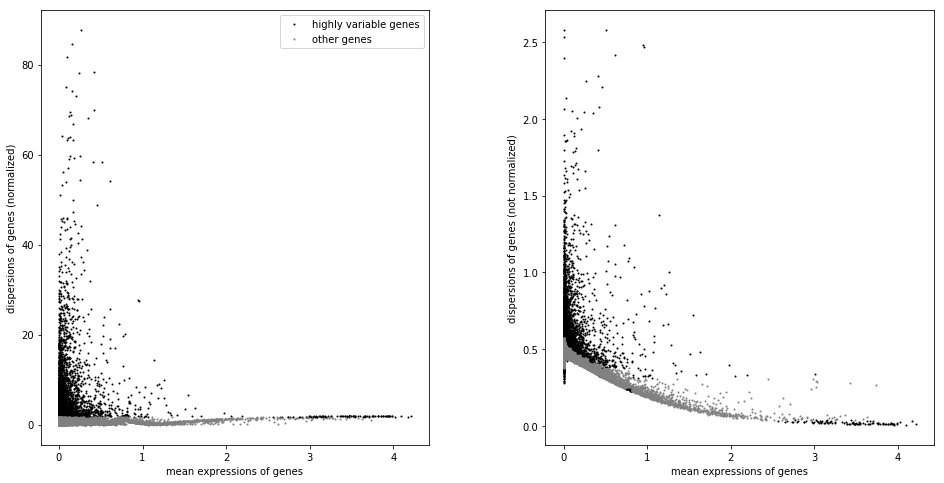

In [19]:
sc.pl.highly_variable_genes(adata)

## 2.5 Visualisation

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. Thus, it is a good idea to look at several visualizations and decide which visualization best represents the aspect of the data that is being investigated.

Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data.

Note that we do not scale the genes to have zero mean and unit variance. A lack of rescaling is equivalent to giving genes with a higher mean expression a higher weight in dimensionality reduction (despite correcting for mean offsets in PCA, due to the mean-variance relationship). We argue that this weighting based on mean expression being a biologically relevant signal. However, rescaling HVG expression is also common, and the number of publications that use this approach suggests that scaling is at least not detrimental to downstream scRNA-seq analysis.

In [20]:
# Calculate the visualizations

sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:34)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:00:45)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:09:13)
computing UMAP
    finished (0:03:47)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9980634  0.997764   0.99745804 0.99723786 0.996267
     0.994575   0.99331063 0.99312985 0.99172395 0.99144185 0.9908494
     0.9905185  0.9902033  0.9900172 ]
    finished (0:00:43)
drawing single-cell graph using layout 'fa'
    finished (0:28:35)


... storing 'exp_number' as categorical
... storing 'stage' as categorical


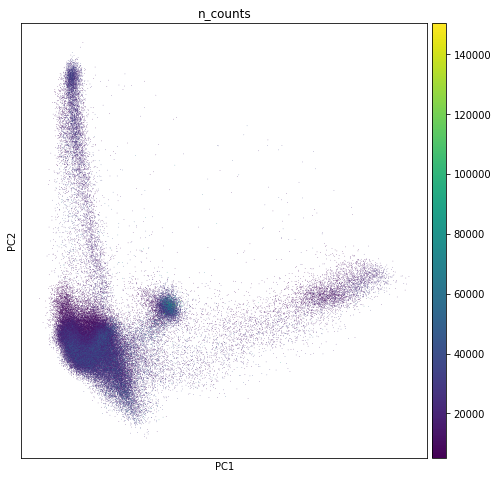

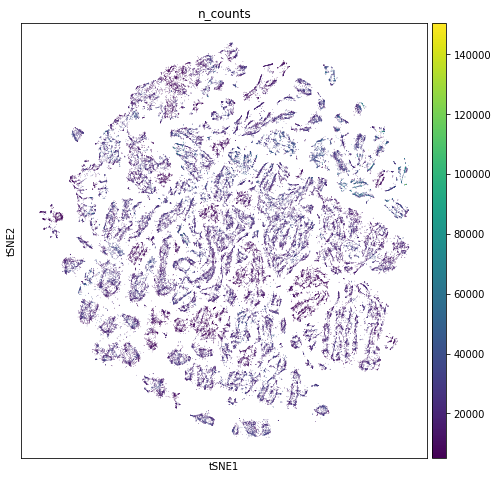

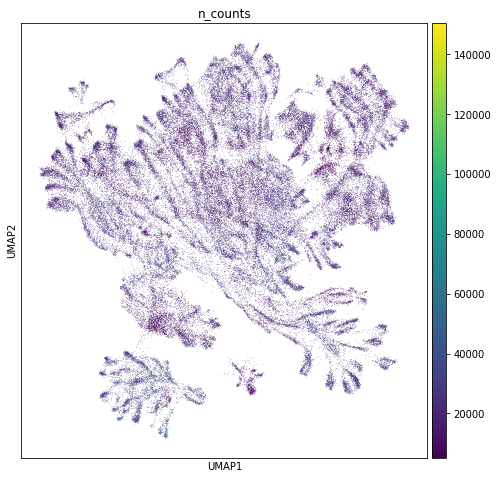

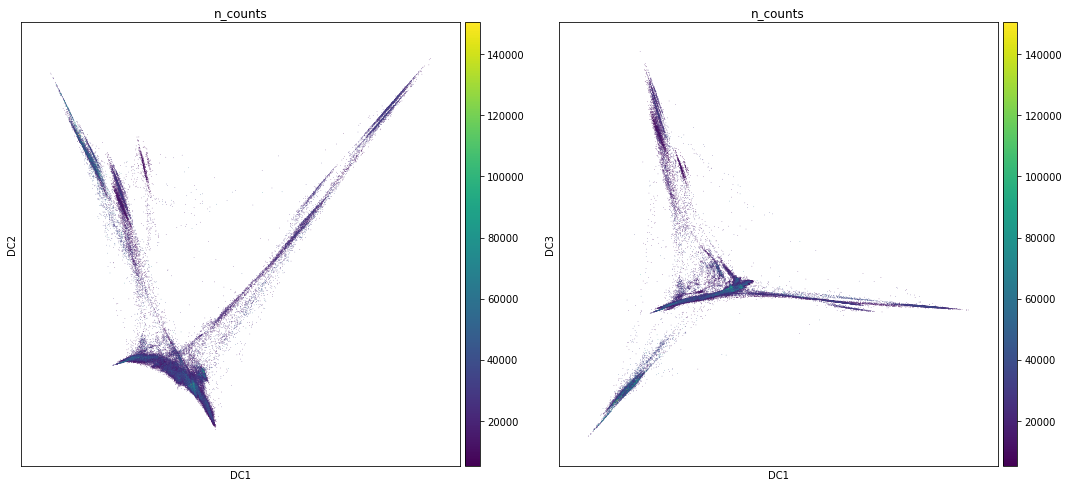

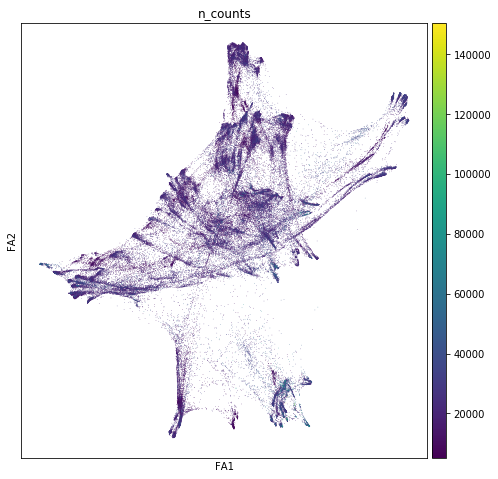

In [21]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.tsne(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

PCA:

- Unsurprisingly, the first principle component captures variation in count depth between cells, and is thus only marginally informative
- The plot does not show the expected clustering of the data in two dimensions

t-SNE:

- Shows many distinct clusters with clear subcluster structure
- Connections between clusters are difficult to interpret visually

UMAP:

- Data points are spread out on the plot showing several clusters
- Connections between clusters can be readily identified

Diffusion Maps:

- Shows connections between regions of higher density
- Very clear trajectories are suggested, but clusters are less clear
- Each diffusion component extracts heterogeneity in a different part of the data

Graph:

- Shows two main clusters and several outer clusters


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:31)


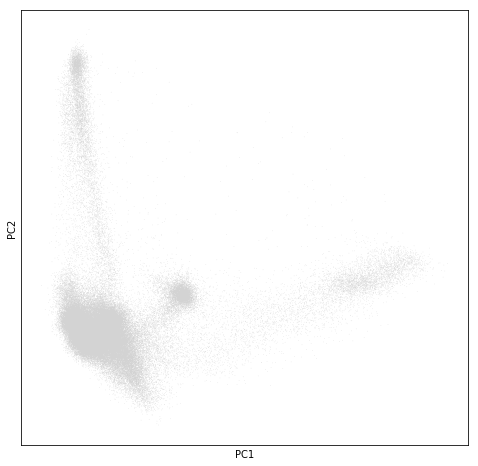

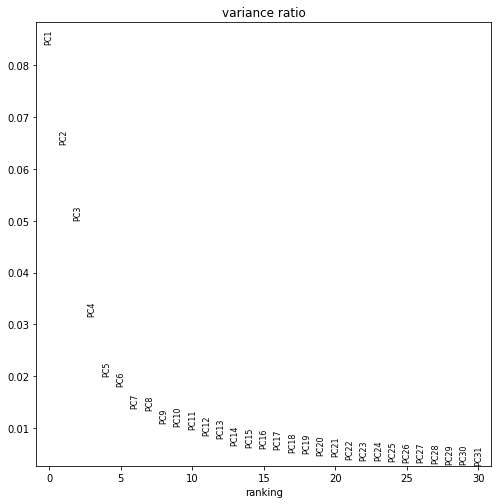

In [22]:
#Recalculating PCA for subset
sc.pp.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)
sc.pl.pca_variance_ratio(adata)

In [23]:
#adata.obsm['X_pca'] = adata.obsm['X_pca'][:,0:20]

## 3 Downstream Analysis

## 3.1 Clustering

Clustering is a central component of the scRNA-seq analysis pipeline. To understand the data, we must identify cell types and states present. The first step of doing so is clustering. Performing Modularity optimization by Louvain community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis. Thus, this is the method of choice in this tutorial as well.

Here, we perform clustering at two resolutions. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph. (see sc.pp.pca() and sc.pp.neighbors() functions used in the visualization section.

[Timing: 8.08s]

In [24]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:28)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:30)


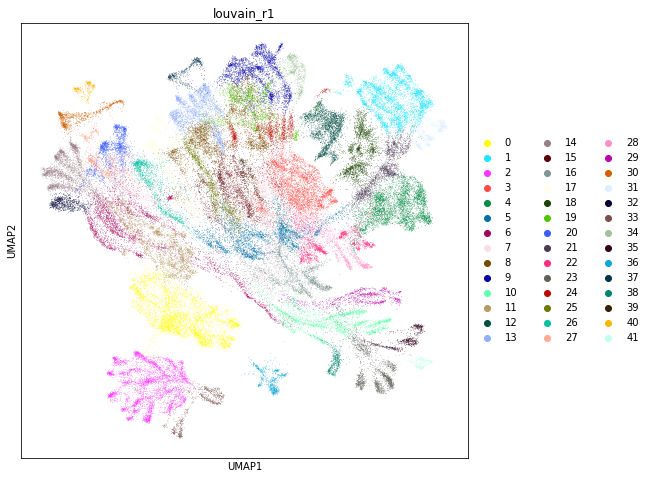

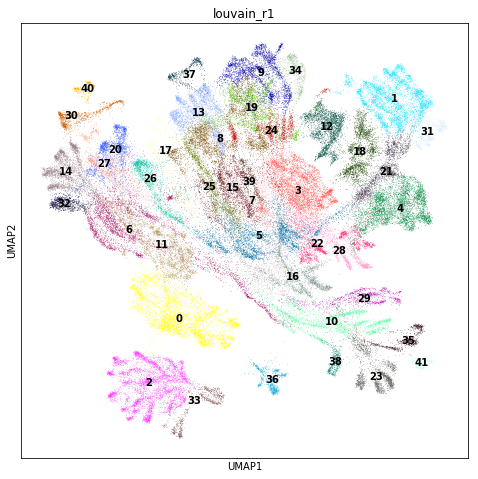

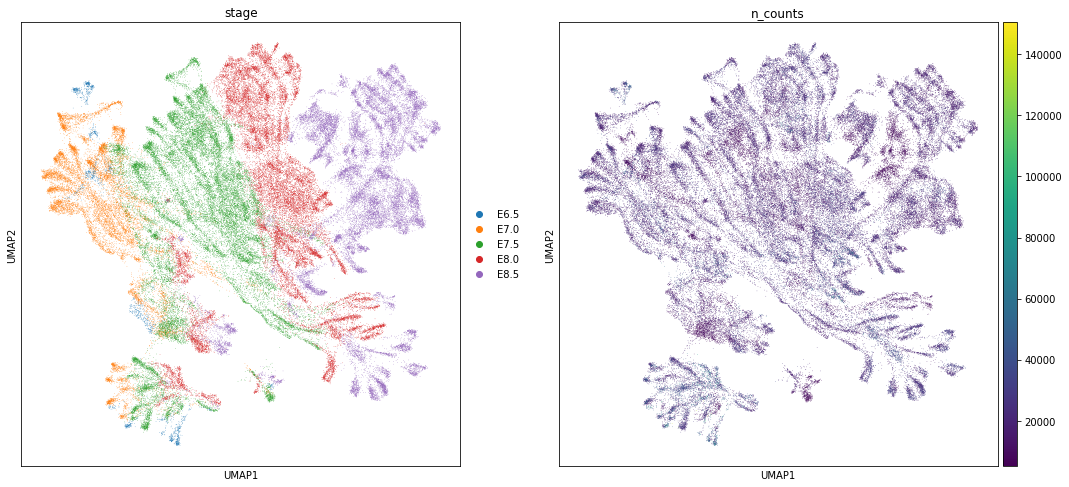

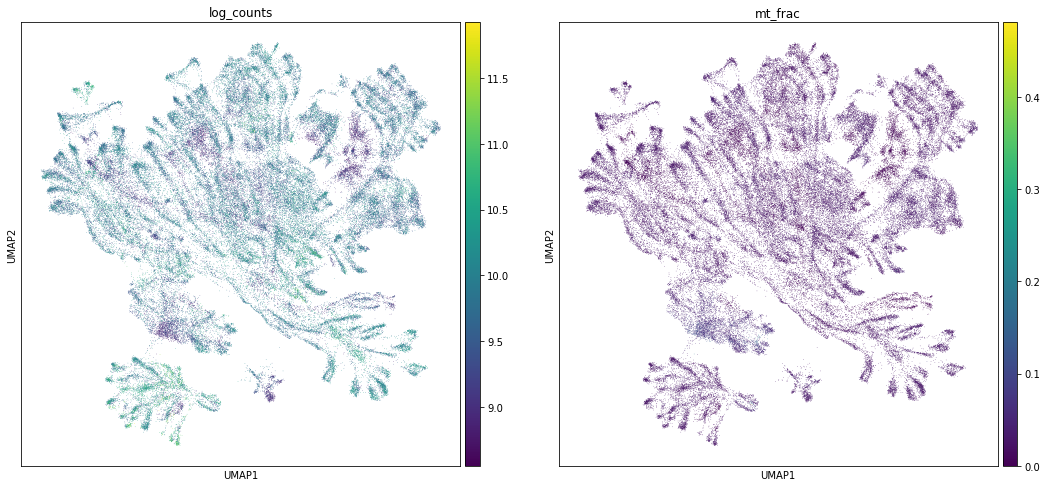

In [25]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1'], palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['louvain_r1'], palette=sc.pl.palettes.default_64, legend_loc = 'on data')
sc.pl.umap(adata, color=['stage', 'n_counts'])
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])

In [26]:
#cluster E6.5

At a resolution of 0.5 the broad clusters in the visualization are captured well in the data. 



# 3.2 Marker Genes & Cluster annotation

To annotate the clusters we obtained, we find genes that are up-regulated in the cluster compared to all other clusters (marker genes). This differential expression test is performed by a Welch t-test with overestimated variance to be conservative. This is the default in scanpy. The test is automatically performed on the .raw data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.



In [27]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')

ranking genes
    finished (0:16:37)


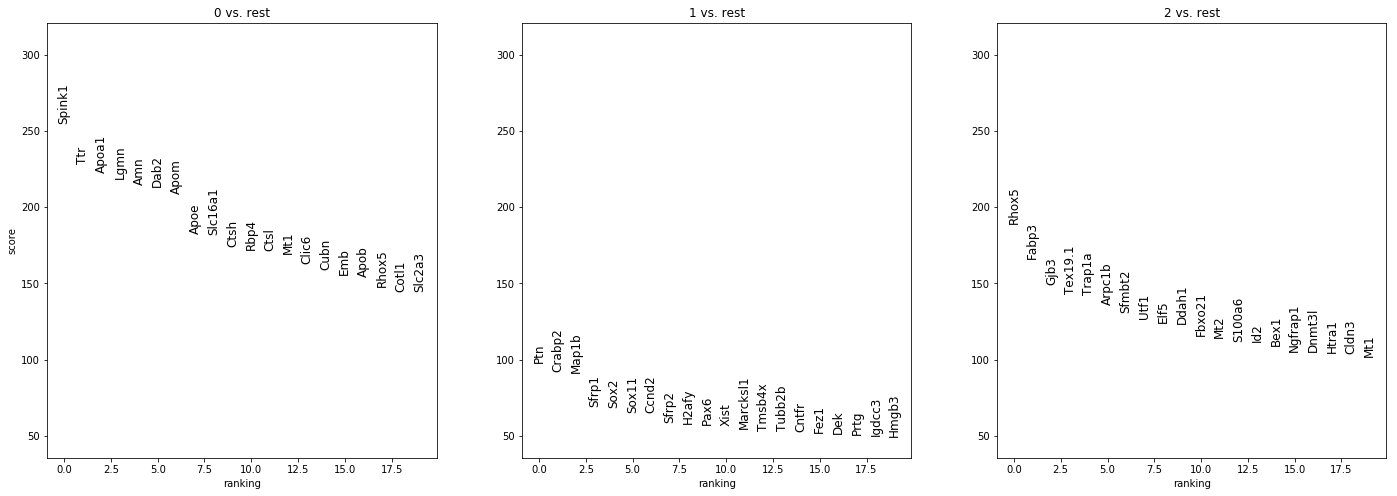

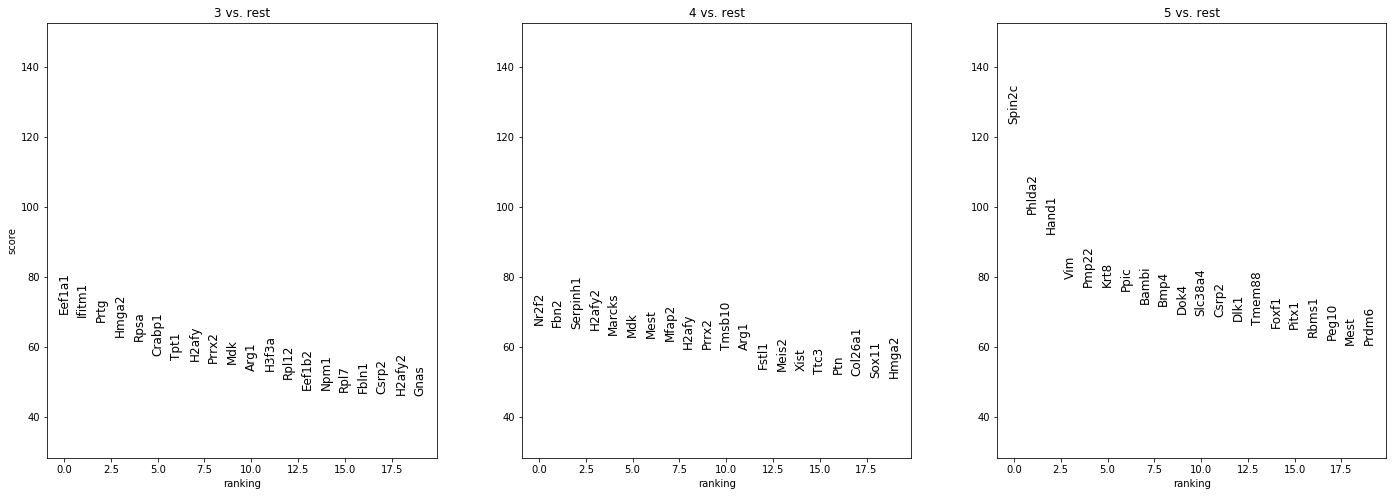

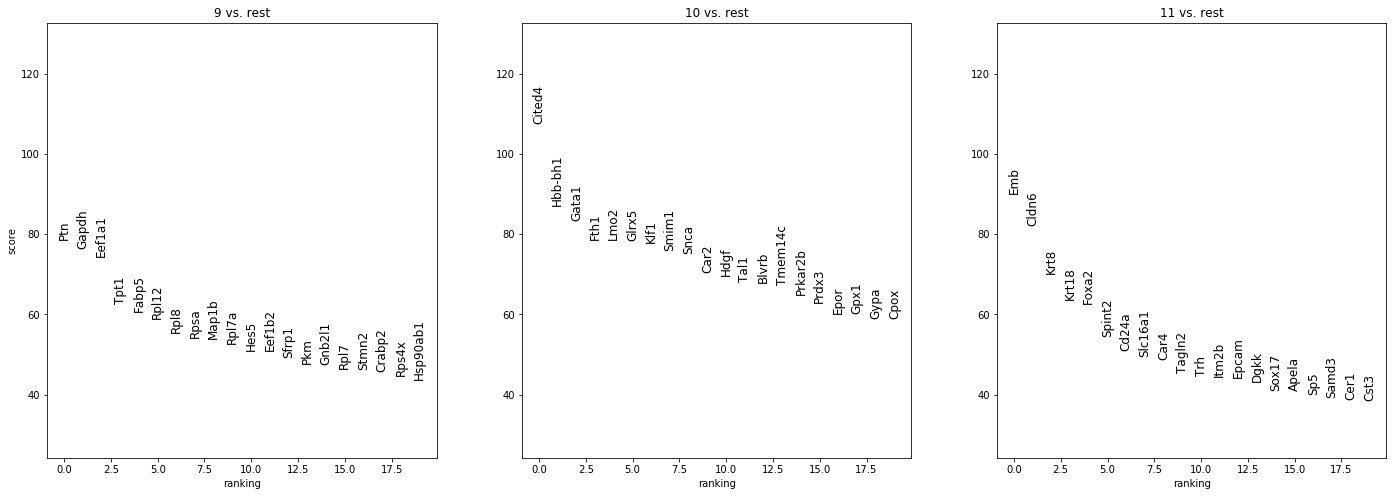

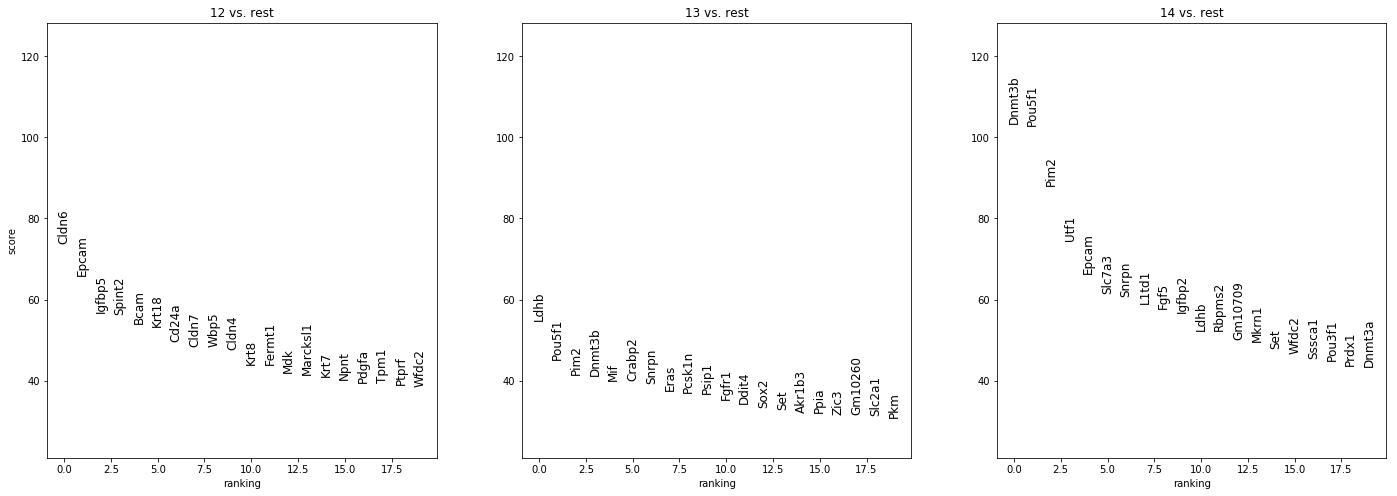

In [28]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['0','1','2'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['3','4','5'], fontsize=12)
#sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['6', '7', '8'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['9', '10', '11'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['12', '13', '14'], fontsize=12)


In [29]:
#Known marker genes:
marker_genes = dict()
marker_genes['Trophoblast stem cells'] = ['Elf5', 'Eomes', 'Cdx2', 'Sox2', 'Esrrb', 'Spry4', 'Ascl2']
marker_genes['Differentiated trophoblasts'] = ['Plac1', 'Elf5', 'Eomes', 'Esrrb', 'Prl3d1', 'Ascl2']
marker_genes['NMPs early']= ['T', 'Evx1', 'Hoxb1', 'Sox3', 'Sp8', 'Nkx1-2', 'Olig3', 'Hoxaas3', 'Cdx1', 'Wnt8a', 'Etv4', 'Nefm', 'Lhpp', 'Hoxa1', 'Hotairm1', 'Epha1', 'Akr1b3', 'Eno1', 'Nr6a1']
marker_genes['Allantois'] = ['Foxf1', 'Tbx4', 'Tbx20', 'Hoxa10', 'Hoxa11', 'Hoxa3']
marker_genes['Epiblast'] = ['Otx2', 'Zic2', 'Fgf5', 'Nodal', 'Utf1', 'Fgf4', 'Rps27rt', 'Snrpn', 'Gng3', 'mt-Atp8', 'Sema6a', 'Gm10036', 'Dnmt3a', 'Bcl11a', 'Dppa5a', 'Zic5', 'Tmem238', 'Pou3f1','L1td1', 'Skil']
marker_genes['Endoderm (Prim/Def)'] = ['Foxa2', 'Sox17', 'Amot', 'Dab2', 'Ttr', 'Spink1', 'Rbp4', 'Spink5', 'Cdh1', 'Slc7a7', 'Kif21a', 'Apom', 'Amn', 'Ctsh', 'Clic6', 'Mt1', 'Apob', 'Cbn']
marker_genes['Trophoblast stem'] = ['Eomes', 'Cdx2', 'Sox2', 'Esrrb', 'Rhox5', 'Efna3', 'Ddah1', 'Htra1', 'Dnmt3l', 'Wnt7b'] 
marker_genes['Ectoderm early 1'] = ['Otx2', 'Zic2', 'Fgf5', 'Utf1', 'Sox2', 'Pou3f1', 'Sox3', 'Hesx1', 'Pim2', 'Dnm3tb', 'Wfdc2', 'Eras']
marker_genes['Ectoderm early 2'] = ['Otx2', 'Zic2', 'Fgf5', 'Utf1', 'Sox2', 'Pou3f1', 'Sox3', 'Six3']
marker_genes['Primitive streak early'] = ['T', 'Evx1', 'Lhx1', 'Mesp1', 'Dll1', 'Tdgf1', 'Eomes']
marker_genes['Primitive streak anterior'] = ['T', 'Evx1', 'Lhx1', 'Foxa2', 'Gsc', 'Eomes']
marker_genes['Primitive streak late'] = ['T', 'Evx1', 'Lhx1', 'Hoxb1']
marker_genes['Splanchnic lateral plate'] = ['Tbx1', 'Tcf21', 'Isl1', 'Prdm1']
marker_genes['Parietal endoderm']=['Col4a2', 'Lama1', 'Lamc1', 'Pth1r', 'Fst', 'Nid1', 'P4ha2', 'Fabp3', 'Tinagl1', 'Kdelr3', 'Hs3st1']
marker_genes['Neural ectoderm posterior'] = ['Aldh1a2', 'Foxc2', 'Fbn2', 'Zfp503', 'Arg1', 'Tcf15', 'Meis2', 'Pax3']
marker_genes['Distal extraembryonic ectoderm'] = ['Rhox5', 'Elf5', 'Eomes', 'Cdx2', 'Sox2', 'Esrrb', 'Eif3j1', 'Cdkn2a', 'Gm1673', 'Zfp42', 'Ndufaf2']
marker_genes['Notochord'] = ['Noto', 'Shh', 'Foxa2', 'Lmx1a', 'Cdh2', 'Alcam', 'Cthrc1', 'Smoc1', 'Vtn', 'Tmod2', 'Lrig3', 'Rab38', 'Rgma', 'Mgst1', 'Smim14', 'Slit2', 'Car3', 'Flrt3', 'Tgfb2', 'Sulf1', 'Col9a1', 'Igfbp5']
marker_genes['Neural crest'] = ['Sox10', 'Sox9', 'Twist', 'Foxd3', 'Tfap2a', 'Hmcn1', 'Dlx2', 'Plp1', 'Nrip1', 'Tfap2b']
marker_genes['Future spinal cord'] = ['Hoxb8', 'Nkx6-1', 'Olig2', 'Sfrp2', 'Crabp2', 'Cntfr', 'Pcsk9', 'Hes5', 'Zfp422', 'Apba2', 'Rfx4', 'Irx3', 'Rarb', '1700011H14Rik', 'Foxb1', 'Spsb4', 'Tubb2b', 'Rnf165', 'Tshz1', 'Fgfbp3']

In [30]:
cell_annotation = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r1')
cell_annotation
#cell_annotation.iloc[:, 9:28]

0     1    2    3    4    5    6    7    8  \
Trophoblast stem cells           0.0   1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   
Differentiated trophoblasts      0.0   0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   
NMPs early                       0.0   0.0  0.0  0.0  0.0  0.0  1.0  0.0  4.0   
Allantois                        0.0   0.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0   
Epiblast                         0.0   0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0   
Endoderm (Prim/Def)             12.0   0.0  2.0  0.0  0.0  1.0  0.0  0.0  0.0   
Trophoblast stem                 1.0   1.0  6.0  0.0  0.0  1.0  2.0  0.0  0.0   
Ectoderm early 1                 0.0   1.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0   
Ectoderm early 2                 0.0   1.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0   
Primitive streak early           0.0   0.0  0.0  0.0  0.0  0.0  5.0  1.0  0.0   
Primitive streak anterior        0.0   0.0  0.0  0.0  0.0  0.0  3.0  0.0  0.0   
Primitive streak late            0.0   0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0   
Splanchnic lateral plate         0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Parietal endoderm                0.0   0.0  2.0  0.0  0.0  1.0  0.0  0.0  0.0   
Neural ectoderm posterior        0.0   0.0  0.0  6.0  6.0  0.0  0.0  0.0  0.0   
Distal extraembryonic ectoderm   1.0   2.0  5.0  0.0  1.0  1.0  1.0  0.0  0.0   
Notochord                        0.0   1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
Neural crest                     0.0   0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
Future spinal cord               0.0  11.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0   

                                  9  ...    32   33   34   35    36   37   38  \
Trophoblast stem cells          1.0  ...   0.0  2.0  1.0  0.0   0.0  1.0  0.0   
Differentiated trophoblasts     0.0  ...   0.0  3.0  0.0  0.0   0.0  0.0  0.0   
NMPs early                      2.0  ...   0.0  0.0  3.0  0.0   0.0  8.0  0.0   
Allantois                       0.0  ...   0.0  0.0  0.0  0.0   0.0  0.0  0.0   
Epiblast                        1.0  ...  10.0  1.0  1.0  0.0   0.0  2.0  0.0   
Endoderm (Prim/Def)             0.0  ...   1.0  1.0  0.0  0.0   1.0  0.0  0.0   
Trophoblast stem                1.0  ...   0.0  1.0  1.0  0.0   0.0  1.0  0.0   
Ectoderm early 1                2.0  ...   6.0  1.0  2.0  0.0   0.0  4.0  0.0   
Ectoderm early 2                2.0  ...   3.0  1.0  2.0  0.0   0.0  1.0  0.0   
Primitive streak early          0.0  ...   0.0  0.0  0.0  0.0   0.0  0.0  0.0   
Primitive streak anterior       0.0  ...   0.0  0.0  0.0  0.0   0.0  0.0  0.0   
Primitive streak late           0.0  ...   0.0  0.0  0.0  0.0   0.0  0.0  0.0   
Splanchnic lateral plate        0.0  ...   0.0  0.0  0.0  0.0   0.0  0.0  0.0   
Parietal endoderm               0.0  ...   1.0  1.0  0.0  0.0  11.0  0.0  0.0   
Neural ectoderm posterior       0.0  ...   0.0  0.0  0.0  0.0   0.0  0.0  0.0   
Distal extraembryonic ectoderm  1.0  ...   0.0  3.0  1.0  0.0   0.0  1.0  0.0   
Notochord                       1.0  ...   0.0  0.0  1.0  0.0   0.0  1.0  0.0   
Neural crest                    0.0  ...   0.0  0.0  0.0  0.0   0.0  0.0  0.0   
Future spinal cord              6.0  ...   0.0  0.0  4.0  0.0   0.0  1.0  0.0   

                                 39    40   41  
Trophoblast stem cells          0.0   0.0  0.0  
Differentiated trophoblasts     0.0   0.0  0.0  
NMPs early                      4.0   0.0  0.0  
Allantois                       0.0   0.0  0.0  
Epiblast                        1.0  13.0  0.0  
Endoderm (Prim/Def)             0.0   2.0  0.0  
Trophoblast stem                0.0   0.0  0.0  
Ectoderm early 1                0.0   5.0  0.0  
Ectoderm early 2                0.0   4.0  0.0  
Primitive streak early          0.0   1.0  0.0  
Primitive streak anterior       0.0   0.0  0.0  
Primitive streak late           1.0   0.0  0.0  
Splanchnic lateral plate        0.0   0.0  0.0  
Parietal endoderm               1.0   0.0  0.0  
Neural ectoderm posterior       5.0   0.0  0.0  
Distal ex

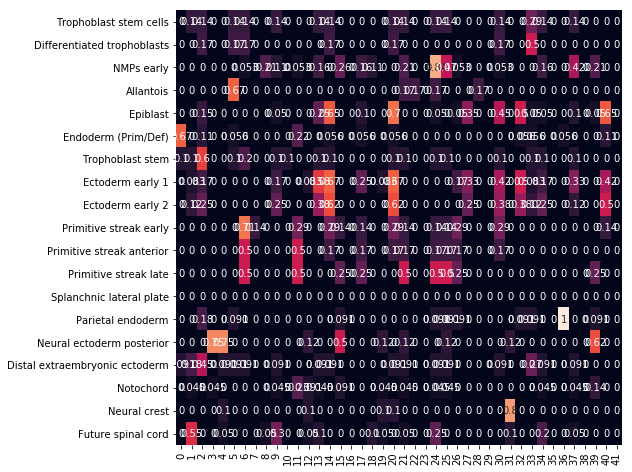

In [31]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r1', normalize='reference')
#sb.heatmap(cell_annotation_norm.iloc[3:, 18:], cbar=False, annot=True)
#hm[]
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [32]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

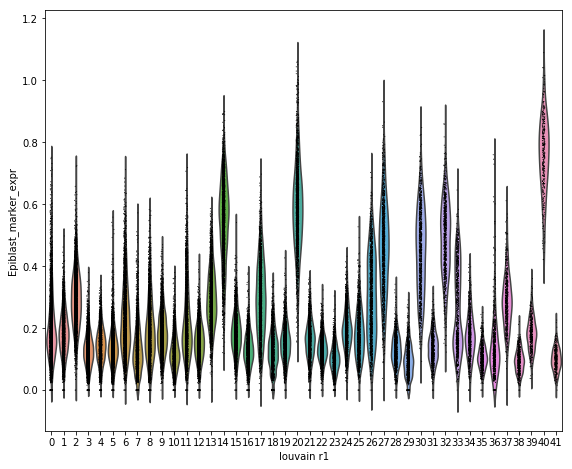

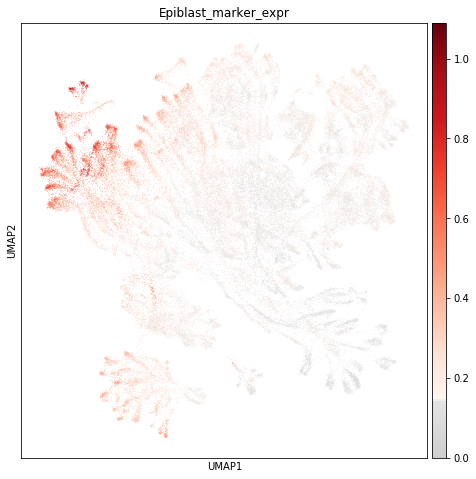

In [33]:
# Check expression of epiblast markers
#Collate all epiblast markers and get the gene IDs in the data set
ids_epiblast = np.in1d(adata.var_names, marker_genes['Epiblast'])

#Calculate the mean expression of epiblast markers
adata.obs['Epiblast_marker_expr'] = adata.X[:,ids_epiblast].mean(1)

#Plot Epiblast expression
sc.pl.violin(adata, 'Epiblast_marker_expr', groupby='louvain_r1')
sc.pl.umap(adata, color='Epiblast_marker_expr', color_map=mymap)


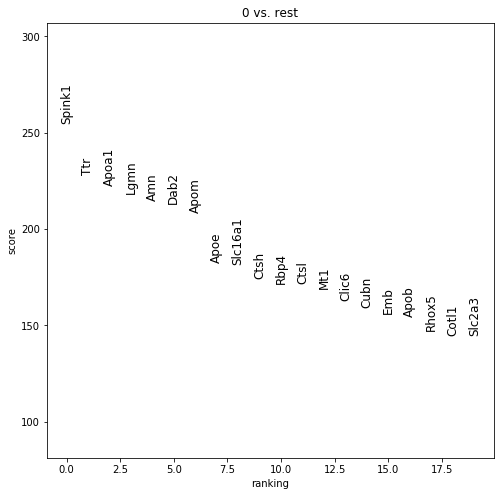

In [34]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['0'], fontsize=12)
#sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['26','28'], fontsize=12)

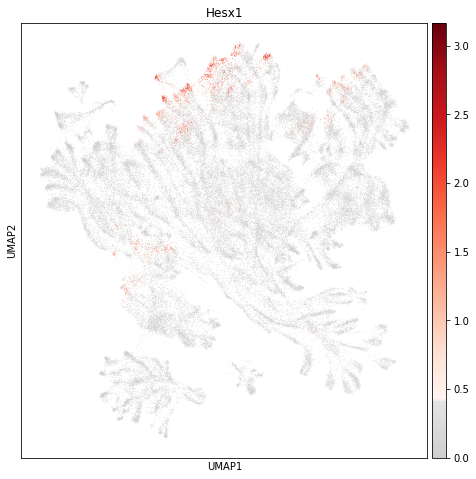

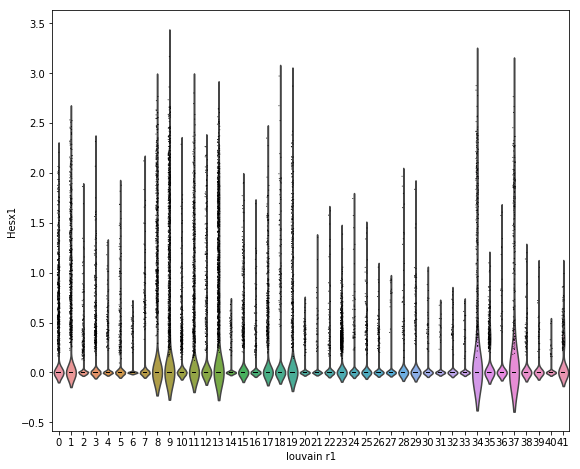

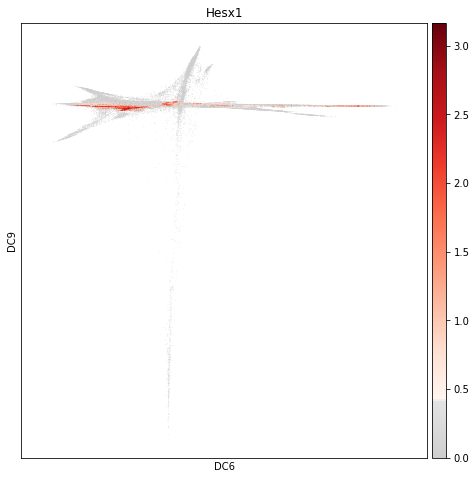

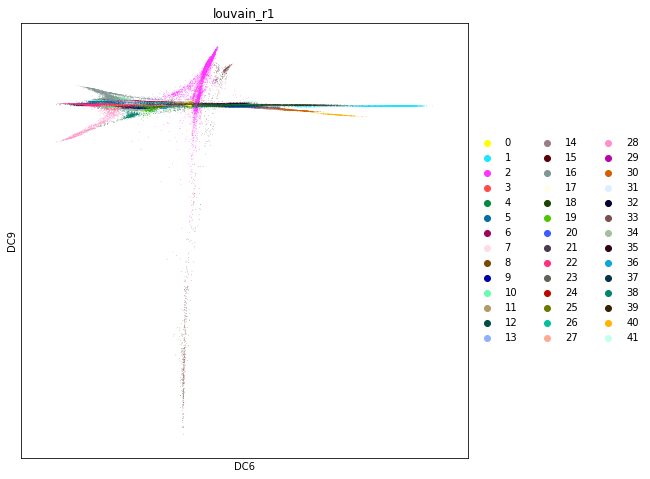

In [35]:

sc.pl.umap(adata, color='Hesx1', use_raw=False, color_map=mymap) 

sc.pl.violin(adata, groupby='louvain_r1', keys='Hesx1', use_raw=False)

sc.pl.diffmap(adata, components=['6,9'], color='Hesx1', use_raw=False, color_map=mymap)
sc.pl.diffmap(adata, components=['6,9'], color='louvain_r1')

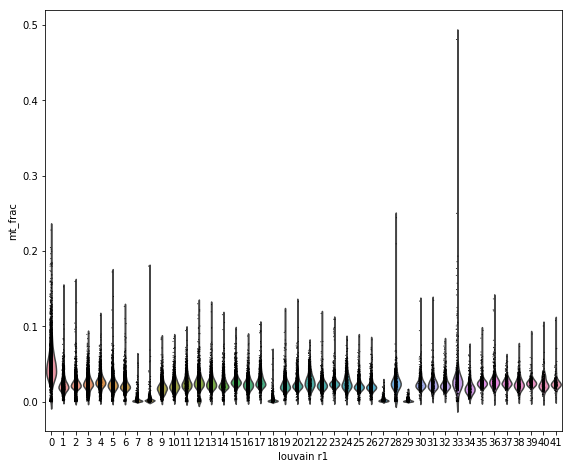

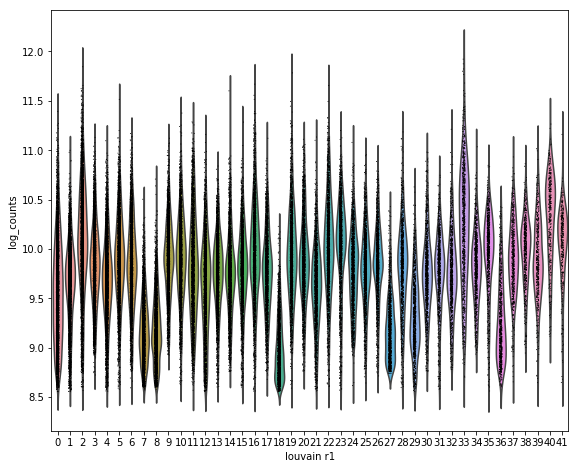

In [36]:
sc.pl.violin(adata, 'mt_frac', groupby='louvain_r1')
sc.pl.violin(adata, 'log_counts', groupby='louvain_r1')

Looking at technical covariates can confirm the 'stressed' phenotype of cluster 0

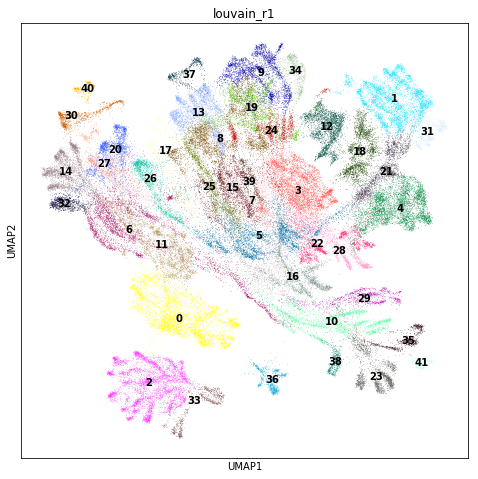

In [37]:
sc.pl.umap(adata, color='louvain_r1', palette=sc.pl.palettes.default_64, legend_loc='on data')

In [38]:
#Categories to rename
adata.obs['louvain_r1'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41'],
      dtype='object')

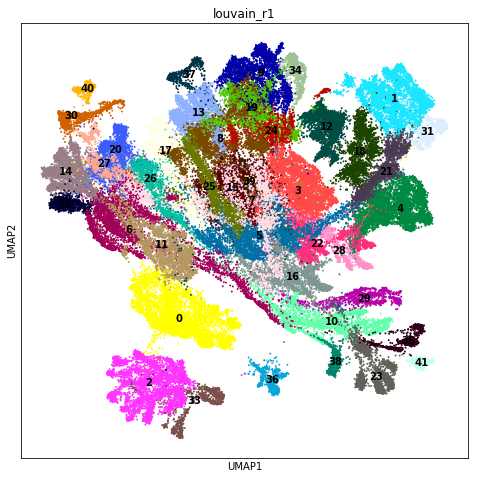

In [39]:
sc.pl.umap(adata, color='louvain_r1', size=15, legend_loc='on data')

## 3.5 Trajectory inference and pseudotime analysis

As our data set contains differentiation processes, we can investigate the differentiation trajectories in the data. This analysis is centred around the concept of 'pseudotime'. In pseudotime analysis a latent variable is inferred based on which the cells are ordered. This latent variable is supposed to measure the differentiation state along a trajectory.

Pseudotime analysis is complicated when there are multiple trajectories in the data. In this case, the trajectory structure in the data must first be found before pseudotime can be inferred along each trajectory. The analysis is then called 'trajectory inference'.

Once the pseudotime variable is inferred, we can test for genes that vary continuously along pseudotime. These genes are seen as being associated with the trajectory, and may play a regulatory role in the potential differentiation trajectory that the analysis found.

##### Here, we measure the trajectory from E6.5_1 to E7.5_1. We also investigate which genes vary along pseudotime.

Based on a recent comparison of pseudotime methods [Saelens et al., 2018], we have selected the top performing 'Slingshot', 'Monocle2', and 'Diffusion Pseudotime (DPT)'. Three methods were chosen as trajectory inference is a complex problem which is not yet solved. Different methods perform well on different types of trajectories. For example, 'Slingshot' was the top performer for simple bifurcating and multifurcating trajectories; 'Monocle2' performed best for complex tree structures, and 'DPT' performed well in bifurcating trajectories and was used in the Haber et al paper from which we took this dataset. As the complexity of trajectories are generally not known, it is adviseable to compare trajectory inference outputs.

[Timing: 63min 42s; Timings for each method given in subsections]

In [40]:
adata.obs['louvain_r1'].value_counts()

0     5511
1     4840
2     4812
3     4646
4     4393
5     4057
6     3767
7     3479
8     3229
9     3146
10    2973
11    2972
12    2798
13    2791
14    2773
15    2520
16    2405
17    2307
18    2301
19    2083
20    2081
21    2049
22    1982
23    1862
24    1653
25    1639
26    1487
27    1317
28    1151
29    1072
30    1069
31     920
32     919
33     916
34     851
35     795
36     777
37     591
38     555
39     444
40     362
41     354
Name: louvain_r1, dtype: int64

In [41]:
adata
import time


In [42]:
#print(adata.var['highly_variable'])
clusters_to_include = [g for g in adata.obs['louvain_r1'].cat.categories]
adata_ent = adata[np.isin(adata.obs['louvain_r1'], clusters_to_include),:].copy()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [43]:
#Subset to highly variable genes
sc.pp.highly_variable_genes(adata_ent, flavor='cell_ranger', n_top_genes=4000, subset=True)

extracting highly variable genes
    finished (0:00:20)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [44]:
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata_ent.var['highly_variable'])))


 Number of highly variable genes: 4000


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:28)


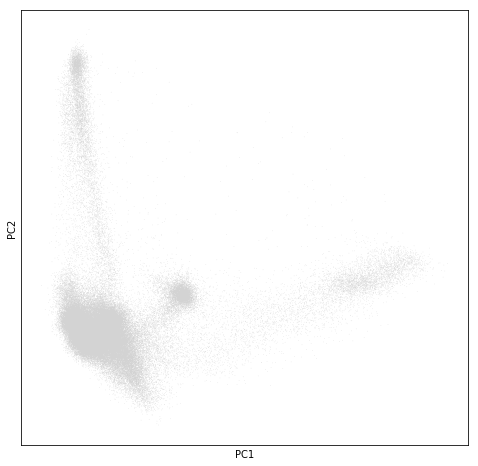

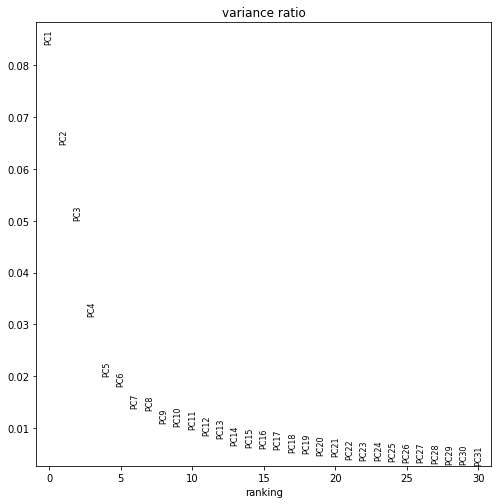

In [45]:
#Recalculating PCA for subset
sc.pp.pca(adata_ent, svd_solver='arpack')
sc.pl.pca(adata_ent)
sc.pl.pca_variance_ratio(adata_ent)

In [46]:
adata_ent.obsm['X_pca'] = adata_ent.obsm['X_pca'][:,0:6]

## 3.5.1 Slingshot

Slingshot is written in R. The integration of R in this notebook is again achieved via the rpy2 interface. We use a specifically developed package called anndata2ri (https://www.github.com/flying-sheep/anndata2ri), that takes care of the conversion from an AnnData object to SingleCellExperiment object in R. It should be noted that the convention for scRNA-seq data matrix storage in R is opposite to python. In R the expression matrix is stored as genes x cells rather than cells x genes. Thus, the matrix must be transposed before being input into the R function. This is already taken care of by anndata2ri.

We are loading the normalized, log-transformed, and batch-corrected data as we want to minimize technical variation in the inferred trajectories.

Implementation note:

this section closely follows the online Slingshot tutorial

In [94]:
#print(adata.obs['stage'])

In [47]:
import time
start = time.time()


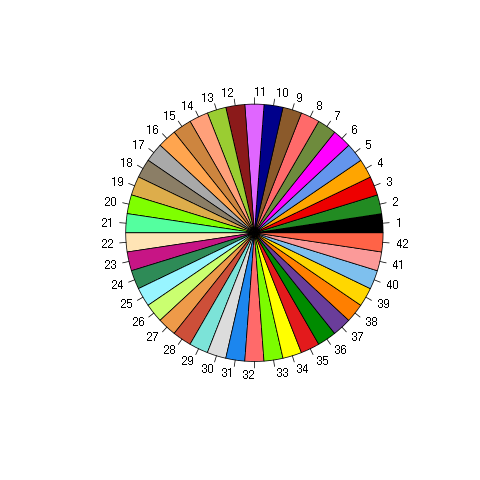

In [190]:
%%R 

manualcolors<-c('black','forestgreen', 'red2', 'orange', 'cornflowerblue', 
                'magenta', 'darkolivegreen4',  
                'indianred1', 'tan4', 'darkblue', 
                'mediumorchid1','firebrick4',  'yellowgreen', 'lightsalmon', 'tan3',
                "tan1",'darkgray', 'wheat4', '#DDAD4B', 'chartreuse', 'seagreen1',
                'moccasin', 'mediumvioletred', 'seagreen','cadetblue1',
                "darkolivegreen1" ,"tan2" ,   "tomato3" , "#7CE3D8","gainsboro", "dodgerblue2",
                "indianred1", "lawngreen", "yellow", "#E31A1C", "green4", "#6A3D9A","#FF7F00", 
                "gold1", "skyblue2", "#FB9A99", "tomato")
pie(rep(1, 42), col = manualcolors)


/home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/anndata2ri/py2r.py:45: UserWarning: Duplicated obs_names: Index(['AAAGATGAGAACAACT_1', 'AAAGATGAGAACAACT_1', 'AACACGTCATCGGGTC_1',
       'AACACGTCATCGGGTC_1', 'AACCATGTCAAGGTAA_1', 'AACCATGTCAAGGTAA_1',
       'AACTTTCAGAAGGTTT_1', 'AACTTTCAGAAGGTTT_1', 'AATCCAGTCGTAGGTT_1',
       'AATCCAGTCGTAGGTT_1',
       ...
       'TGGCTGGGTATGAATG_1', 'TGGCTGGGTATGAATG_1', 'TTAGTTCAGGCAGGTT_1',
       'TTAGTTCAGGCAGGTT_1', 'TTATGCTTCCGCGTTT_1', 'TTATGCTTCCGCGTTT_1',
       'TTCCCAGAGAGACTAT_1', 'TTCCCAGAGAGACTAT_1', 'TTTATGCCAGCGTCCA_1',
       'TTTATGCCAGCGTCCA_1'],
      dtype='object', length=204)
  warn(f"Duplicated {name}: {idx[idx.duplicated(False)].sort_values()}")
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


[1] "1:"
class: SlingshotDataSet 

 Samples Dimensions
   92649          6

lineages: 12 
Lineage1: 40  32  30  26  17  25  15  39  3  21  4  31  18  
Lineage2: 40  32  30  26  17  25  5  16  36  33  2  
Lineage3: 40  32  30  26  17  13  37  19  9  34  1  
Lineage4: 40  32  30  26  6  10  38  35  23  41  
Lineage5: 40  32  30  26  17  25  5  22  28  
Lineage6: 40  32  30  26  17  13  37  19  12  
Lineage7: 40  32  30  26  17  13  37  24  
Lineage8: 40  32  30  26  17  11  0  
Lineage9: 40  32  30  26  17  13  8  
Lineage10: 40  32  30  26  6  10  29  
Lineage11: 40  32  30  26  6  7  
Lineage12: 40  32  20  14  27  

curves: 12 
Curve1: Length: 22.637	Samples: 29774.08
Curve2: Length: 30.411	Samples: 25158.95
Curve3: Length: 15.977	Samples: 24044.03
Curve4: Length: 29.395	Samples: 20308.49
Curve5: Length: 25.117	Samples: 21940.81
Curve6: Length: 22.133	Samples: 19124.63
Curve7: Length: 15.09	Samples: 17674.07
Curve8: Length: 34.387	Samples: 18993.62
Curve9: Length: 15.336	Samples: 1812

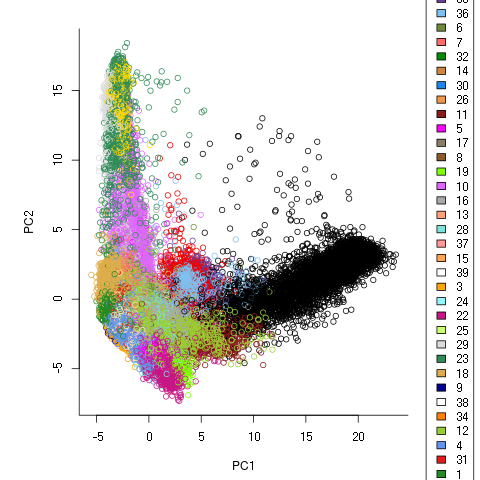

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [49]:
%%R -i adata_ent -o adata_ent_start -o adata_ent_startend


#Plot 1
colour_map = manualcolors
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,5))
plot(reducedDims(adata_ent)$PCA[,1], reducedDims(adata_ent)$PCA[,2], col=colour_map[colData(adata_ent)$louvain_r1], bty='L', xlab='PC1', ylab='PC2')
legend("right", inset=c(-0.2,0), legend=unique(colData(adata_ent)$louvain_r1), fill=colour_map[as.integer(unique(colData(adata_ent)$louvain_r1))])

#First trajectory: Epiblast set as root cells
print("1:")
adata_ent_start <- slingshot(adata_ent, clusterLabels = 'louvain_r1', reducedDim = 'PCA', start.clus='40')
print(SlingshotDataSet(adata_ent_start))
print("")

#Start and endpoint specified
print("2:")
adata_ent_startend <- slingshot(adata_ent, clusterLabels = 'louvain_r1', reducedDim = 'PCA', start.clus='40', end.clus='31')
print(SlingshotDataSet(adata_ent_startend))

print("")

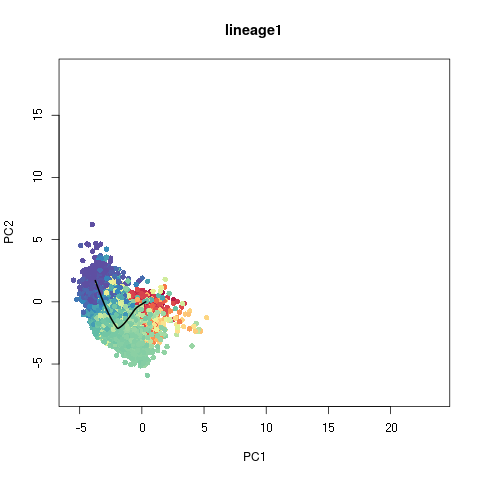

In [107]:
%%R 
#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(13,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_start)$PCA[,c(1,2)], col = colors[cut(adata_ent_start$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2', main="lineage1")
lines(slingCurves(adata_ent_start)$curve1, lwd=2)

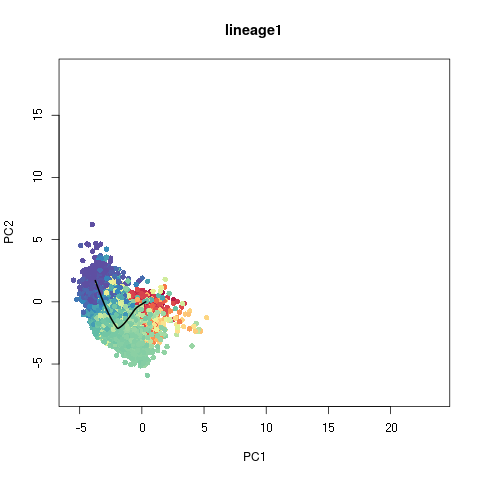

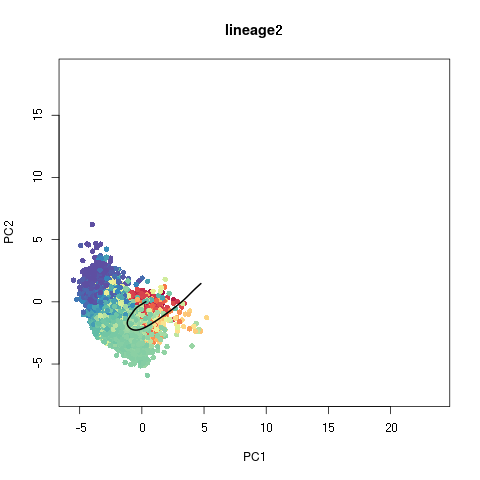

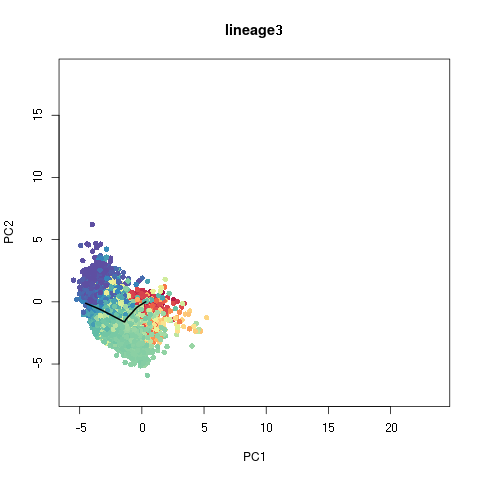

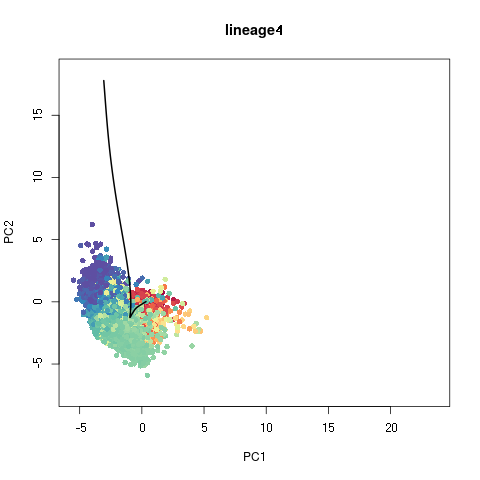

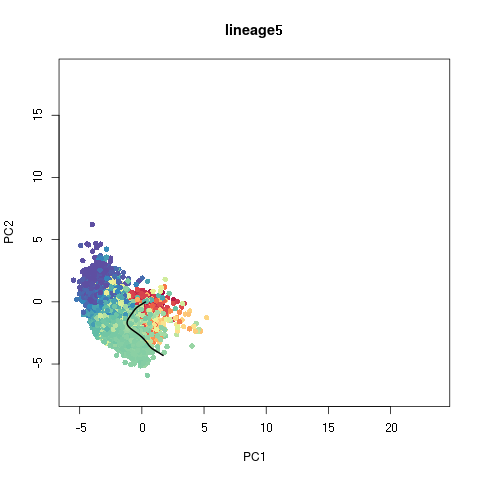

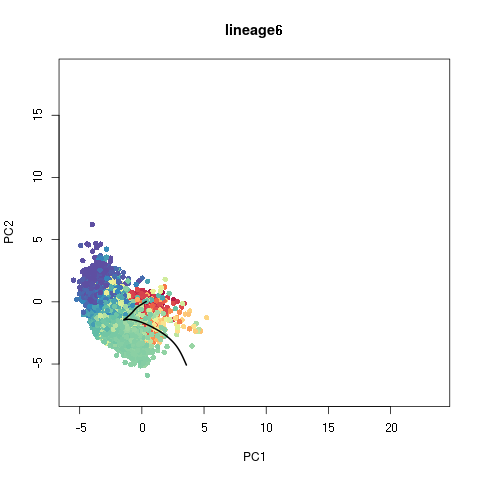

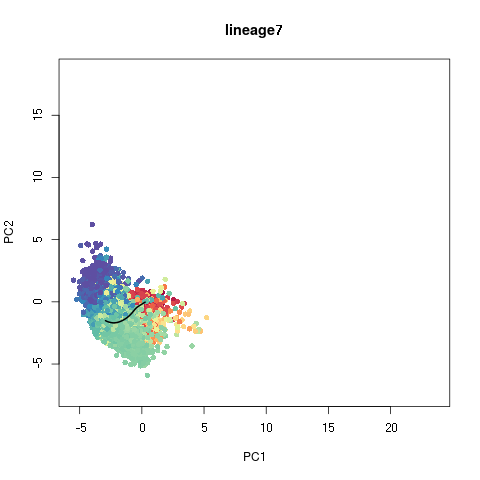

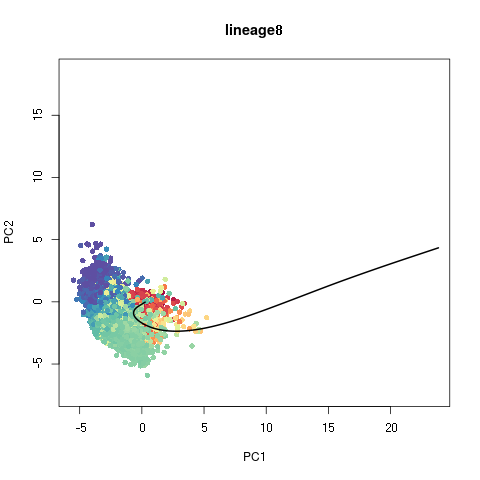

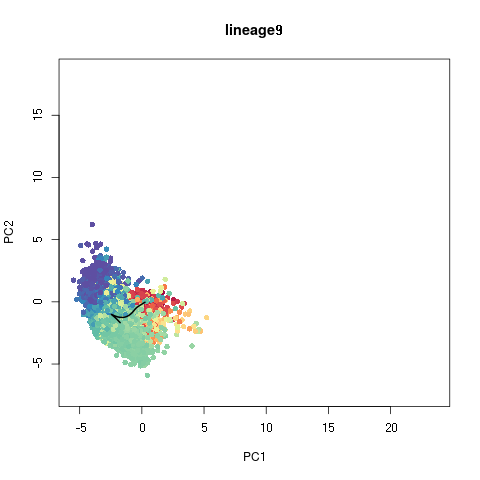

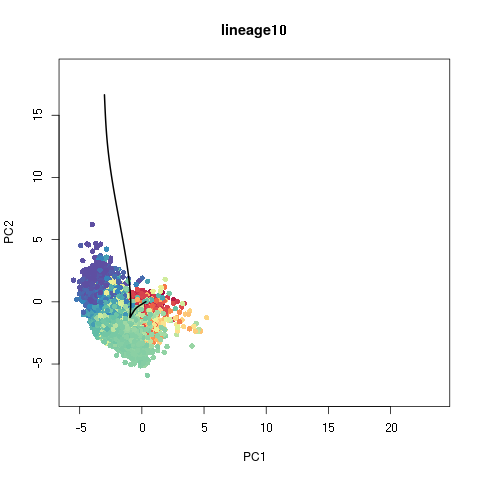

In [50]:
%%R

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(13,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_start)$PCA[,c(1,2)], col = colors[cut(adata_ent_start$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2', main="lineage1")
lines(slingCurves(adata_ent_start)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(13,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_start)$PCA[,c(1,2)], col = colors[cut(adata_ent_start$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2', main="lineage2")
lines(slingCurves(adata_ent_start)$curve2, lwd=2)

#Plot of lineage 3
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_start)$PCA[,c(1,2)], col = colors[cut(adata_ent_start$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2', main="lineage3")
lines(slingCurves(adata_ent_start)$curve3, lwd=2)

#Plot of lineage 4
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_start)$PCA[,c(1,2)], col = colors[cut(adata_ent_start$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2', main="lineage4")
lines(slingCurves(adata_ent_start)$curve4, lwd=2)


#Plot of lineage 5
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_start)$PCA[,c(1,2)], col = colors[cut(adata_ent_start$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2', main="lineage5")
lines(slingCurves(adata_ent_start)$curve5, lwd=2)

#Plot of lineage 6
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_start)$PCA[,c(1,2)], col = colors[cut(adata_ent_start$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2', main="lineage6")
lines(slingCurves(adata_ent_start)$curve6, lwd=2)


#Plot of lineage 7
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_start)$PCA[,c(1,2)], col = colors[cut(adata_ent_start$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2', main="lineage7")
lines(slingCurves(adata_ent_start)$curve7, lwd=2)


#Plot of lineage 8
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_start)$PCA[,c(1,2)], col = colors[cut(adata_ent_start$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2', main="lineage8")
lines(slingCurves(adata_ent_start)$curve8, lwd=2)


#Plot of lineage 9
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_start)$PCA[,c(1,2)], col = colors[cut(adata_ent_start$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2', main="lineage9")
lines(slingCurves(adata_ent_start)$curve9, lwd=2)


#Plot of lineage 10
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_start)$PCA[,c(1,2)], col = colors[cut(adata_ent_start$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2', main="lineage10")
lines(slingCurves(adata_ent_start)$curve10, lwd=2)

In [51]:
print(time.time() - start)

249557.40228176117


This took 249557.4 seconds. Very long.

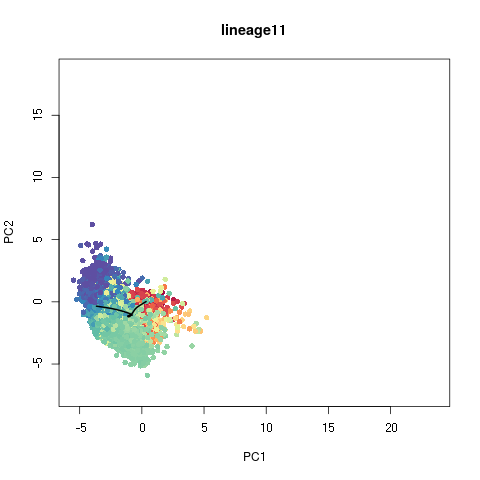

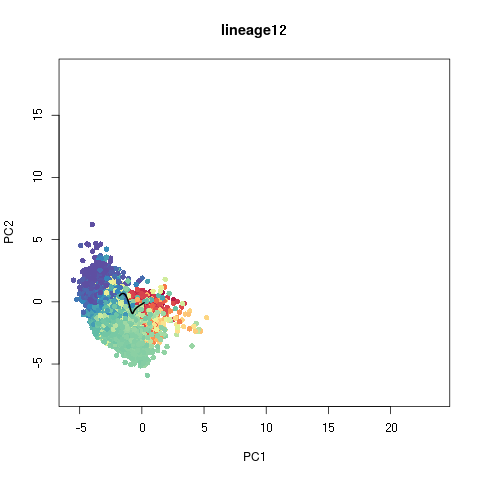

In [52]:
%%R
#Plot of lineage 11
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_start)$PCA[,c(1,2)], col = colors[cut(adata_ent_start$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2', main="lineage11")
lines(slingCurves(adata_ent_start)$curve11, lwd=2)


#Plot of lineage 12
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_start)$PCA[,c(1,2)], col = colors[cut(adata_ent_start$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2', main="lineage12")
lines(slingCurves(adata_ent_start)$curve12, lwd=2)

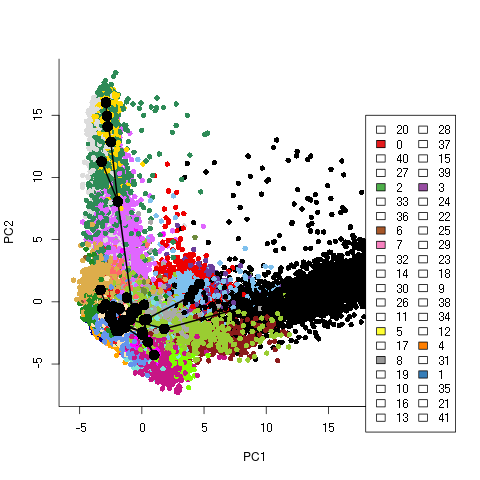

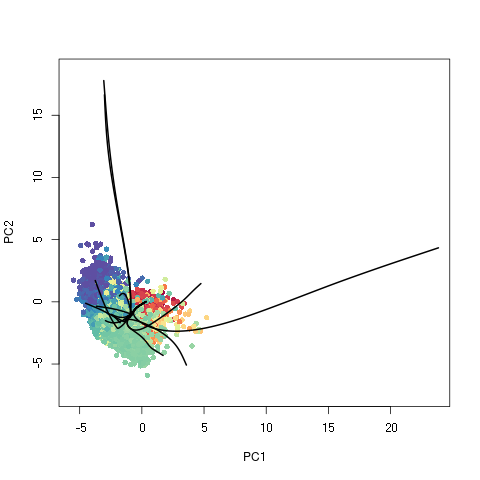

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [53]:
%%R -o adata_ent_start
#Plot of lineages with clusters visualized
par(xpd=TRUE)
plot(reducedDims(adata_ent_start)$PCA[,c(1,2)], col=colour_map[adata_ent$louvain_r1], pch=16, asp = 1, bty='L', xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_ent_start), lwd=2, type='lineages')
legend(x=18, y=15, ncol = 2, legend=unique(colData(adata_ent)$louvain_r1), fill=brewer.pal(13,'Set1')[as.integer(unique(colData(adata_ent)$louvain_r1))])

#Plot of simpler clustering
plot(reducedDims(adata_ent_start)$PCA[,c(1,2)], col = colors[cut(adata_ent_start$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_ent_start), lwd=2)

In [124]:
#Split data into our known time points
e65 = adata_ent_start[0:1843,:]
e70 = adata_ent_start[1844:15294,:]
e75 = adata_ent_start[15295:43528,:]
e80 = adata_ent_start[43529:67870,:]
e85 = adata_ent_start[67871:,:]

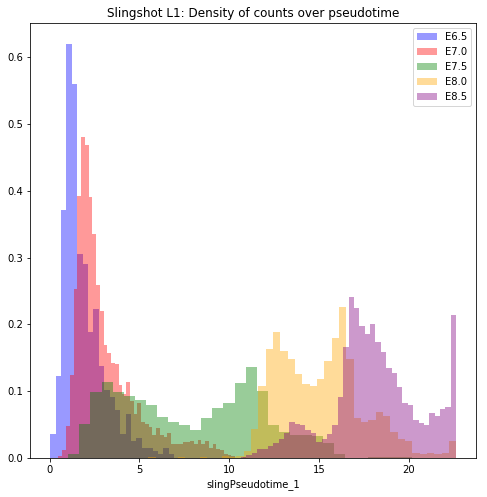

In [130]:
#Plot histogram of no cells over pseudotime
import scipy.stats
from scipy.stats import norm

p1 = sb.distplot(e65.obs['slingPseudotime_1'].dropna(), kde=False, color = 'b', norm_hist=True)
p2 = sb.distplot(e70.obs['slingPseudotime_1'].dropna(), kde=False, color = 'r', norm_hist=True)
p3 = sb.distplot(e75.obs['slingPseudotime_1'].dropna(), kde=False, color = 'g', norm_hist=True)
p4 = sb.distplot(e80.obs['slingPseudotime_1'].dropna(), kde=False, color = 'orange', norm_hist=True)
p5 = sb.distplot(e85.obs['slingPseudotime_1'].dropna(), kde=False, color = 'purple', norm_hist=True)
plt.title('Slingshot L1: Density of counts over pseudotime')
plt.legend(('E6.5', 'E7.0', 'E7.5', 'E8.0', 'E8.5'))
plt.show()


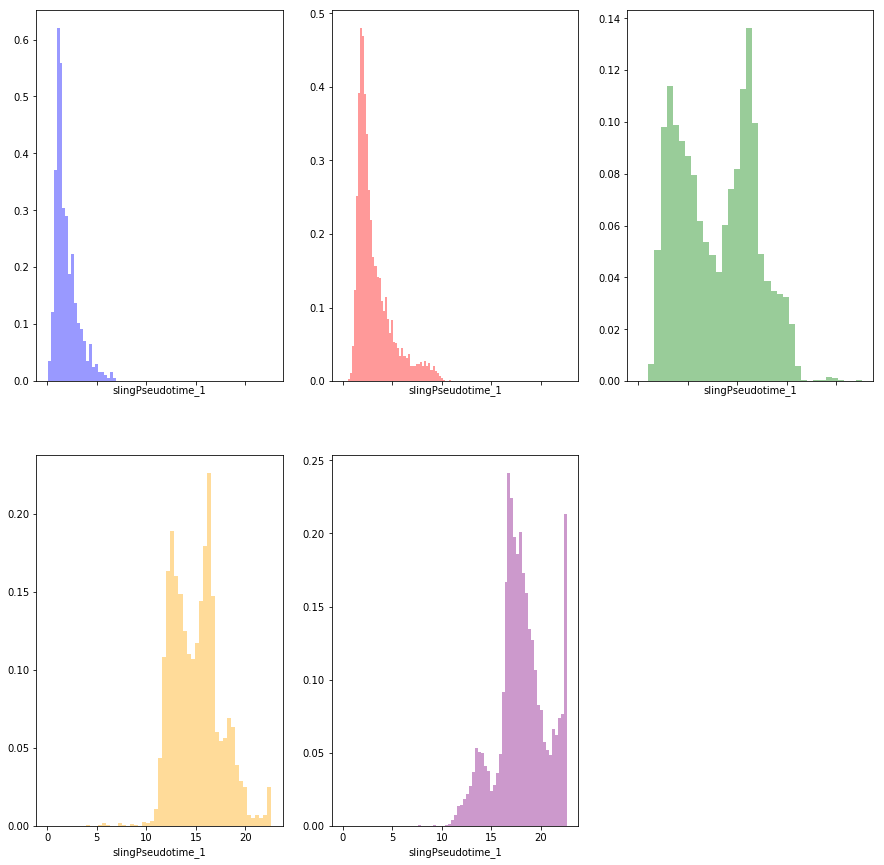

In [150]:
f, axes = plt.subplots(2,3, figsize = (15,15), sharex=True)
sb.distplot(e65.obs['slingPseudotime_1'].dropna(), kde=False, color = 'b', norm_hist=True, ax = axes[0,0])
sb.distplot(e70.obs['slingPseudotime_1'].dropna(), kde=False, color = 'r', norm_hist=True, ax = axes[0,1])
sb.distplot(e75.obs['slingPseudotime_1'].dropna(), kde=False, color = 'g', norm_hist=True, ax = axes[0,2])
sb.distplot(e80.obs['slingPseudotime_1'].dropna(), kde=False, color = 'orange', norm_hist=True, ax = axes[1,0])
sb.distplot(e85.obs['slingPseudotime_1'].dropna(), kde=False, color = 'purple', norm_hist=True, ax = axes[1,1])
f.delaxes(axes[1,2])

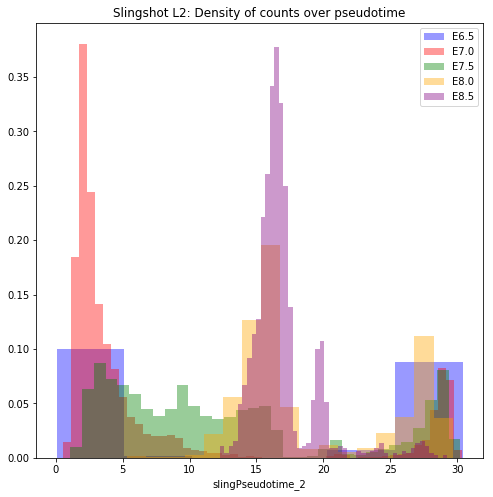

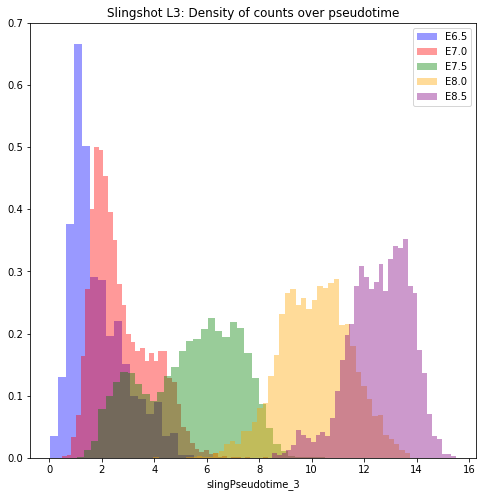

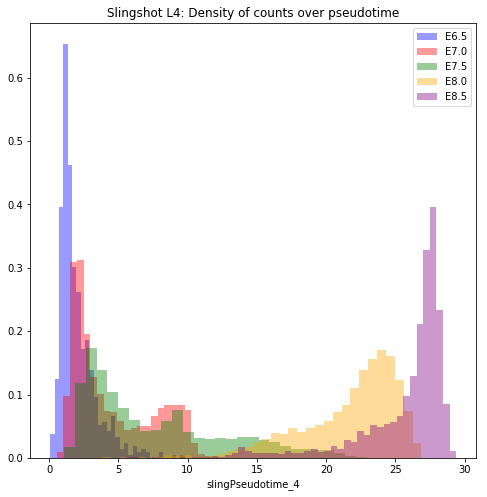

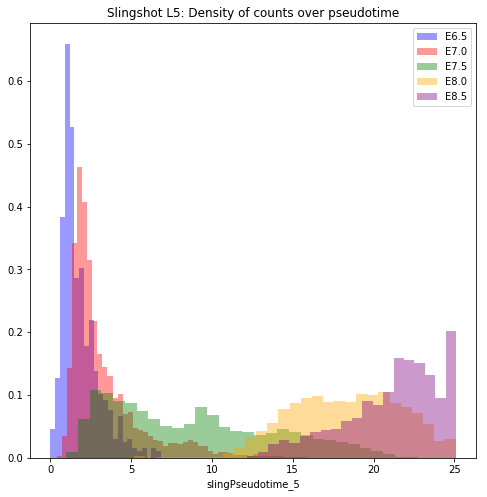

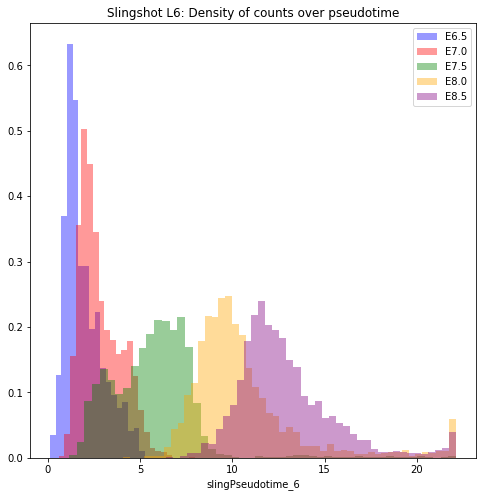

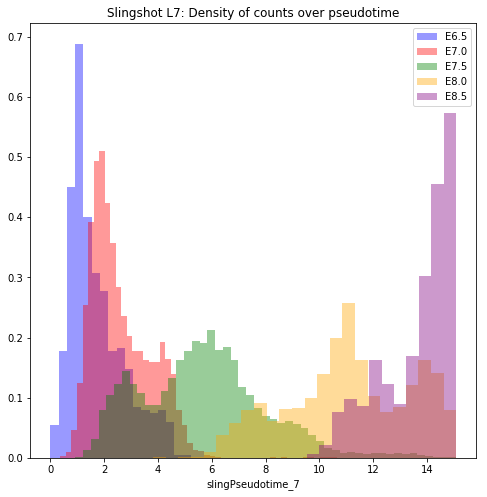

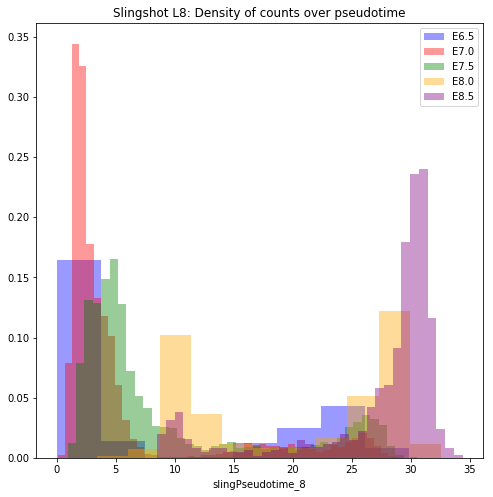

In [131]:
#Others
p1 = sb.distplot(e65.obs['slingPseudotime_2'].dropna(), kde=False, color = 'b', norm_hist=True)
p2 = sb.distplot(e70.obs['slingPseudotime_2'].dropna(), kde=False, color = 'r', norm_hist=True)
p3 = sb.distplot(e75.obs['slingPseudotime_2'].dropna(), kde=False, color = 'g', norm_hist=True)
p4 = sb.distplot(e80.obs['slingPseudotime_2'].dropna(), kde=False, color = 'orange', norm_hist=True)
p5 = sb.distplot(e85.obs['slingPseudotime_2'].dropna(), kde=False, color = 'purple', norm_hist=True)
plt.title('Slingshot L2: Density of counts over pseudotime')
plt.legend(('E6.5', 'E7.0', 'E7.5', 'E8.0', 'E8.5'))
plt.show()

p1 = sb.distplot(e65.obs['slingPseudotime_3'].dropna(), kde=False, color = 'b', norm_hist=True)
p2 = sb.distplot(e70.obs['slingPseudotime_3'].dropna(), kde=False, color = 'r', norm_hist=True)
p3 = sb.distplot(e75.obs['slingPseudotime_3'].dropna(), kde=False, color = 'g', norm_hist=True)
p4 = sb.distplot(e80.obs['slingPseudotime_3'].dropna(), kde=False, color = 'orange', norm_hist=True)
p5 = sb.distplot(e85.obs['slingPseudotime_3'].dropna(), kde=False, color = 'purple', norm_hist=True)
plt.title('Slingshot L3: Density of counts over pseudotime')
plt.legend(('E6.5', 'E7.0', 'E7.5', 'E8.0', 'E8.5'))
plt.show()


p1 = sb.distplot(e65.obs['slingPseudotime_4'].dropna(), kde=False, color = 'b', norm_hist=True)
p2 = sb.distplot(e70.obs['slingPseudotime_4'].dropna(), kde=False, color = 'r', norm_hist=True)
p3 = sb.distplot(e75.obs['slingPseudotime_4'].dropna(), kde=False, color = 'g', norm_hist=True)
p4 = sb.distplot(e80.obs['slingPseudotime_4'].dropna(), kde=False, color = 'orange', norm_hist=True)
p5 = sb.distplot(e85.obs['slingPseudotime_4'].dropna(), kde=False, color = 'purple', norm_hist=True)
plt.title('Slingshot L4: Density of counts over pseudotime')
plt.legend(('E6.5', 'E7.0', 'E7.5', 'E8.0', 'E8.5'))
plt.show()


p1 = sb.distplot(e65.obs['slingPseudotime_5'].dropna(), kde=False, color = 'b', norm_hist=True)
p2 = sb.distplot(e70.obs['slingPseudotime_5'].dropna(), kde=False, color = 'r', norm_hist=True)
p3 = sb.distplot(e75.obs['slingPseudotime_5'].dropna(), kde=False, color = 'g', norm_hist=True)
p4 = sb.distplot(e80.obs['slingPseudotime_5'].dropna(), kde=False, color = 'orange', norm_hist=True)
p5 = sb.distplot(e85.obs['slingPseudotime_5'].dropna(), kde=False, color = 'purple', norm_hist=True)
plt.title('Slingshot L5: Density of counts over pseudotime')
plt.legend(('E6.5', 'E7.0', 'E7.5', 'E8.0', 'E8.5'))
plt.show()


p1 = sb.distplot(e65.obs['slingPseudotime_6'].dropna(), kde=False, color = 'b', norm_hist=True)
p2 = sb.distplot(e70.obs['slingPseudotime_6'].dropna(), kde=False, color = 'r', norm_hist=True)
p3 = sb.distplot(e75.obs['slingPseudotime_6'].dropna(), kde=False, color = 'g', norm_hist=True)
p4 = sb.distplot(e80.obs['slingPseudotime_6'].dropna(), kde=False, color = 'orange', norm_hist=True)
p5 = sb.distplot(e85.obs['slingPseudotime_6'].dropna(), kde=False, color = 'purple', norm_hist=True)
plt.title('Slingshot L6: Density of counts over pseudotime')
plt.legend(('E6.5', 'E7.0', 'E7.5', 'E8.0', 'E8.5'))
plt.show()

p1 = sb.distplot(e65.obs['slingPseudotime_7'].dropna(), kde=False, color = 'b', norm_hist=True)
p2 = sb.distplot(e70.obs['slingPseudotime_7'].dropna(), kde=False, color = 'r', norm_hist=True)
p3 = sb.distplot(e75.obs['slingPseudotime_7'].dropna(), kde=False, color = 'g', norm_hist=True)
p4 = sb.distplot(e80.obs['slingPseudotime_7'].dropna(), kde=False, color = 'orange', norm_hist=True)
p5 = sb.distplot(e85.obs['slingPseudotime_7'].dropna(), kde=False, color = 'purple', norm_hist=True)
plt.title('Slingshot L7: Density of counts over pseudotime')
plt.legend(('E6.5', 'E7.0', 'E7.5', 'E8.0', 'E8.5'))
plt.show()

p1 = sb.distplot(e65.obs['slingPseudotime_8'].dropna(), kde=False, color = 'b', norm_hist=True)
p2 = sb.distplot(e70.obs['slingPseudotime_8'].dropna(), kde=False, color = 'r', norm_hist=True)
p3 = sb.distplot(e75.obs['slingPseudotime_8'].dropna(), kde=False, color = 'g', norm_hist=True)
p4 = sb.distplot(e80.obs['slingPseudotime_8'].dropna(), kde=False, color = 'orange', norm_hist=True)
p5 = sb.distplot(e85.obs['slingPseudotime_8'].dropna(), kde=False, color = 'purple', norm_hist=True)
plt.title('Slingshot L8: Density of counts over pseudotime')
plt.legend(('E6.5', 'E7.0', 'E7.5', 'E8.0', 'E8.5'))
plt.show()

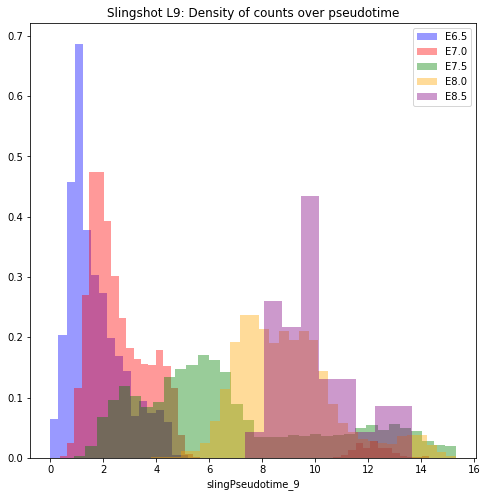

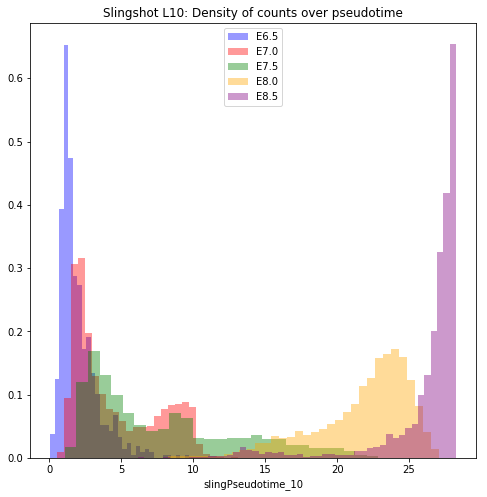

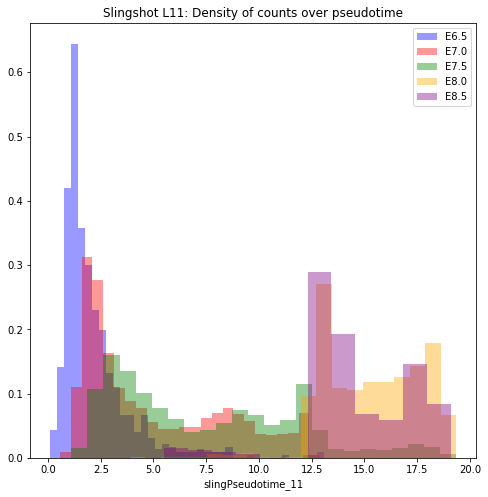

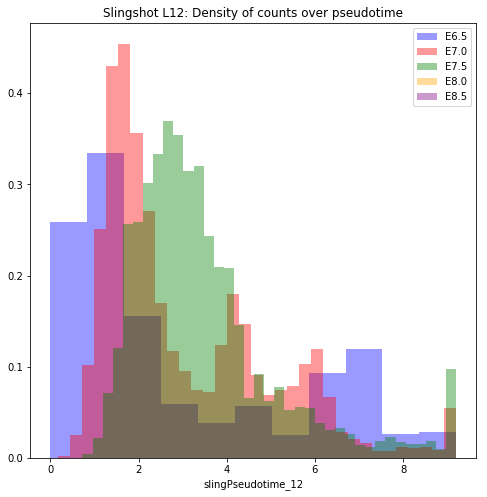

In [133]:
p1 = sb.distplot(e65.obs['slingPseudotime_9'].dropna(), kde=False, color = 'b', norm_hist=True)
p2 = sb.distplot(e70.obs['slingPseudotime_9'].dropna(), kde=False, color = 'r', norm_hist=True)
p3 = sb.distplot(e75.obs['slingPseudotime_9'].dropna(), kde=False, color = 'g', norm_hist=True)
p4 = sb.distplot(e80.obs['slingPseudotime_9'].dropna(), kde=False, color = 'orange', norm_hist=True)
p5 = sb.distplot(e85.obs['slingPseudotime_9'].dropna(), kde=False, color = 'purple', norm_hist=True)
plt.title('Slingshot L9: Density of counts over pseudotime')
plt.legend(('E6.5', 'E7.0', 'E7.5', 'E8.0', 'E8.5'))
plt.show()

p1 = sb.distplot(e65.obs['slingPseudotime_10'].dropna(), kde=False, color = 'b', norm_hist=True)
p2 = sb.distplot(e70.obs['slingPseudotime_10'].dropna(), kde=False, color = 'r', norm_hist=True)
p3 = sb.distplot(e75.obs['slingPseudotime_10'].dropna(), kde=False, color = 'g', norm_hist=True)
p4 = sb.distplot(e80.obs['slingPseudotime_10'].dropna(), kde=False, color = 'orange', norm_hist=True)
p5 = sb.distplot(e85.obs['slingPseudotime_10'].dropna(), kde=False, color = 'purple', norm_hist=True)
plt.title('Slingshot L10: Density of counts over pseudotime')
plt.legend(('E6.5', 'E7.0', 'E7.5', 'E8.0', 'E8.5'))
plt.show()

p1 = sb.distplot(e65.obs['slingPseudotime_11'].dropna(), kde=False, color = 'b', norm_hist=True)
p2 = sb.distplot(e70.obs['slingPseudotime_11'].dropna(), kde=False, color = 'r', norm_hist=True)
p3 = sb.distplot(e75.obs['slingPseudotime_11'].dropna(), kde=False, color = 'g', norm_hist=True)
p4 = sb.distplot(e80.obs['slingPseudotime_11'].dropna(), kde=False, color = 'orange', norm_hist=True)
p5 = sb.distplot(e85.obs['slingPseudotime_11'].dropna(), kde=False, color = 'purple', norm_hist=True)
plt.title('Slingshot L11: Density of counts over pseudotime')
plt.legend(('E6.5', 'E7.0', 'E7.5', 'E8.0', 'E8.5'))
plt.show()


p1 = sb.distplot(e65.obs['slingPseudotime_12'].dropna(), kde=False, color = 'b', norm_hist=True)
p2 = sb.distplot(e70.obs['slingPseudotime_12'].dropna(), kde=False, color = 'r', norm_hist=True)
p3 = sb.distplot(e75.obs['slingPseudotime_12'].dropna(), kde=False, color = 'g', norm_hist=True)
p4 = sb.distplot(e80.obs['slingPseudotime_12'].dropna(), kde=False, color = 'orange', norm_hist=True)
p5 = sb.distplot(e85.obs['slingPseudotime_12'].dropna(), kde=False, color = 'purple', norm_hist=True)
plt.title('Slingshot L12: Density of counts over pseudotime')
plt.legend(('E6.5', 'E7.0', 'E7.5', 'E8.0', 'E8.5'))
plt.show()


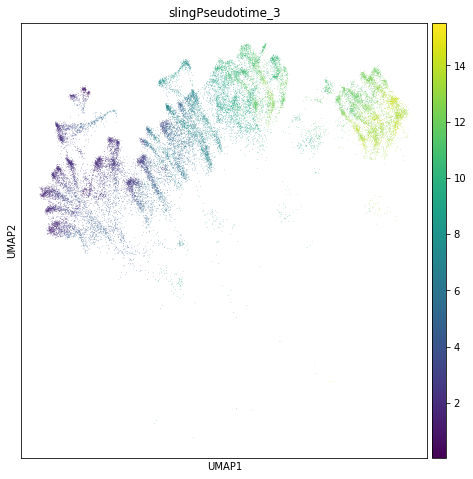

In [151]:
sc.pl.umap(adata_ent_start, color=['slingPseudotime_3'], palette=sc.pl.palettes.default_64)

## 3.7 Metastable states

In order to detect metastable states across a trajectory we can plot a histogram of the pseudotime variable for one lineage. Here, we plot the density across a non-batch-corrected Slingshot lineage where start states were defined. We colour the histogram by the most common cell-type cluster in each pseudotime bin. This shows us which clusters are dominant states along the trajectory.

[1] 42


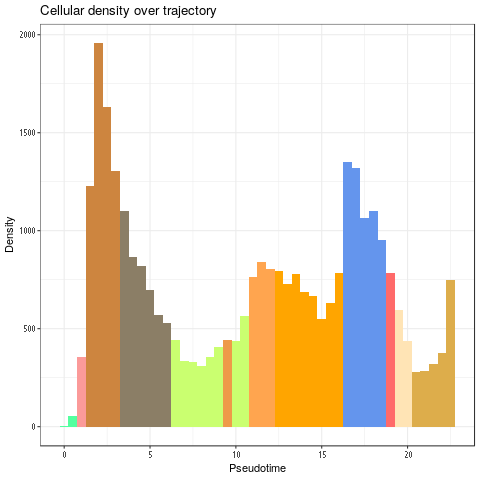

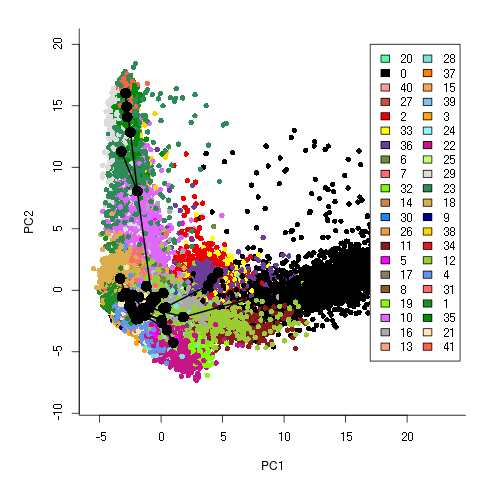

In [191]:
%%R

pt1 <- adata_ent_start$slingPseudotime_1
clustDat <- adata_ent_start$louvain_r1

#Subset data to only include cells on lineage 1
clustDat <- clustDat[!is.na(pt1)]
pt1 <- pt1[!is.na(pt1)]
df = data.frame(clusters = clustDat, pt = pt1)

#Bin clusters in same way as pseudotime:
bin_width = 0.5
max_bin = ceiling(max(df$pt)*2)/2
df['bins'] = cut(df$pt, breaks=seq(-bin_width/2, max_bin, bin_width))

#Find dominant cluster in each bin
Mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

dominant_clusters = sapply(levels(df$bins), function(x){Mode(df$clusters[df$bins==x])})
levels(dominant_clusters) <- c(levels(dominant_clusters), 'None')
dominant_clusters[is.na(dominant_clusters)] <- 'None'

#Define colour map
cmap <- manualcolors
print(length(cmap))

#Plot meta-stable states
p <- qplot(adata_ent_start$slingPseudotime_1, geom='histogram', main='Cellular density over trajectory', xlab='Pseudotime', ylab='Density', binwidth=bin_width, fill=I(cmap[dominant_clusters])) +
theme_bw()
print(p)

#Plot of lineages with clusters visualized
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,1))
plot(reducedDims(adata_ent_start)$PCA[,c(1,2)], col = manualcolors[adata_ent$louvain_r1], pch=16, asp = 1, bty='L', xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_ent_start), lwd=2, type='lineages')
legend(x=17, y=20, ncol = 2, legend=unique(colData(adata_ent)$louvain_r1), fill=cmap[as.integer(unique(colData(adata_ent)$louvain_r1))])

## 3.5.3 Monocle2

The monocle toolbox is one of the most popular trajectory inference toolboxes in the field. It has been shown to perform particularly well on complex trajectories. Although we only have a simple bi- or multifurcating trajectory here we use Monocle2 to confirm the obtained trajectory.

Monocle2 is not as much a standalone trajectory inference method, than a trajectory inference toolbox. This toolbox includes preprocessing steps and a dimensionality reduction function. It is designed in such a way that integrating preprocessed data into the data structure is non-trivial. This is likely by intent to not interfere with the optimized pipeline. Thus, we use Monocle2 on our data set from the raw data. Our cluster labels are later overlayed onto the Monocle2 output to compare the trajectory with expectations.

Unfortunately some issue with memory size of data prohibited me from using this.

In [112]:
#Preprocessing for monocle
data_mat_mon = adata.layers['counts'].T
var_mon=adata.var.copy()
obs_mon=adata.obs.copy()

In [113]:
#print(data_mat_mon)

In [114]:
%%R -i data_mat_mon -i obs_mon -i var_mon

#Set up the CellDataSet data structure
pd <- AnnotatedDataFrame(data = obs_mon)
fd <- AnnotatedDataFrame(data = var_mon)
colnames(data_mat_mon) <- rownames(pd)
rownames(data_mat_mon) <- rownames(fd)
ie_regions_cds <- newCellDataSet(cellData=data_mat_mon, phenoData=pd, featureData=fd, expressionFamily=negbinomial.size())

#Normalize the count data
ie_regions_cds <- estimateSizeFactors(ie_regions_cds)

#Calculate dispersions to filter for highly variable genes
ie_regions_cds <- estimateDispersions(ie_regions_cds)

#Filter 
cell_types = as.character(pData(ie_regions_cds)$louvain_r1)
cell_mask = rep(FALSE, length(cell_types))

print("Number of cells after filtering:")
print(sum(cell_mask))
print("")

#Filter highly variable genes from our analysis
hvg_mask = fData(ie_regions_cds)$highly_variable
ie_regions_cds <- ie_regions_cds[hvg_mask, cell_mask]

#Do dimensionality reduction
ie_regions_cds <- reduceDimension(ie_regions_cds, norm_method = 'vstExprs', reduction_method='DDRTree', verbose = F, max_components = 7)

#Run for the first time to get the ordering
ie_regions_cds <- orderCells(ie_regions_cds)

#Find the correct root state the corresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$louvain_r1)
id = which(colnames(tab1) == '40')
root_name = names(which.max(tab1[,id]))

#Run a second time to get the correct root state that overlaps with Stem cells
ie_regions_cds <- orderCells(ie_regions_cds, root_state=root_name)


Error in validityMethod(as(object, superClass)) : 
  long vectors not supported yet: ../../src/include/Rinlinedfuns.h:519
Calls: <Anonymous> ... validObject -> anyStrings -> isTRUE -> validityMethod


### 3.5.4 Diffusion Pseudotime (DPT)

Finally, we include Diffusion Pseudotime in the analysis to further support the found trajectories. Diffusion pseudotime is integrated into scanpy and is therefore easy to use with the current setup.

DPT is based on diffusion maps, thus a diffusion map representation must be calculated prior to pseudotime inference. This in turn is based on a KNN graph embedding obtained from sc.pp.neighbors().

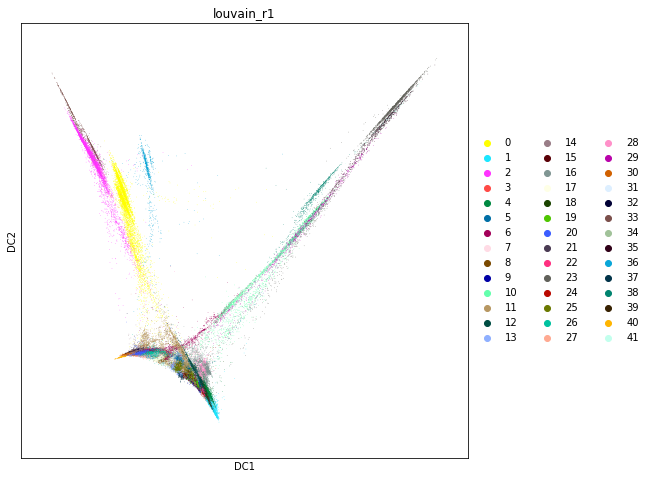

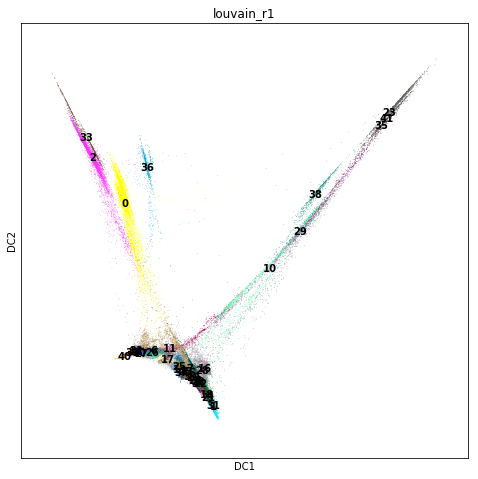

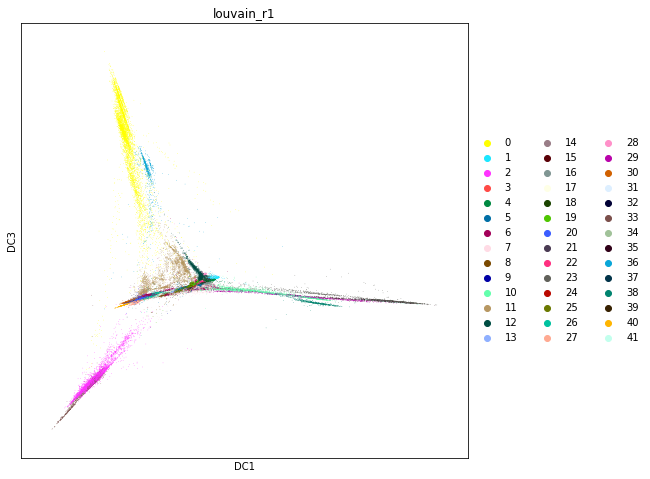

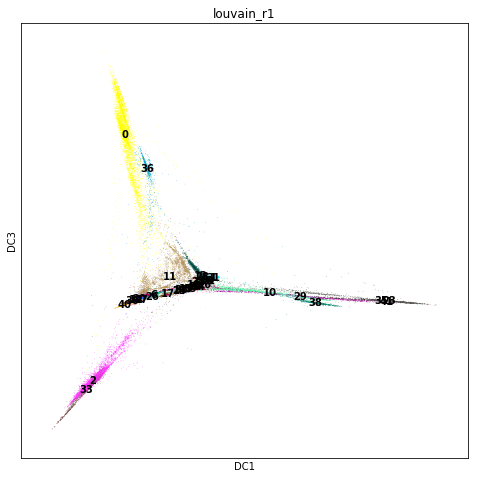

In [65]:
sc.pl.diffmap(adata, components='1,2', color='louvain_r1')
sc.pl.diffmap(adata, components='1,2', color='louvain_r1', legend_loc = 'on data')
sc.pl.diffmap(adata, components='1,3', color='louvain_r1')
sc.pl.diffmap(adata, components='1,3', color='louvain_r1', legend_loc = 'on data')

In [68]:
#Find the stem cell with the highest DC3 value to act as root for the diffusion pseudotime and compute DPT
stem_mask = np.isin(adata.obs['louvain_r1'], '40')
max_stem_id = np.argmin(adata.obsm['X_diffmap'][stem_mask,2])
root_id = np.arange(len(stem_mask))[stem_mask][max_stem_id]
adata.uns['iroot'] = root_id

#Compute dpt
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


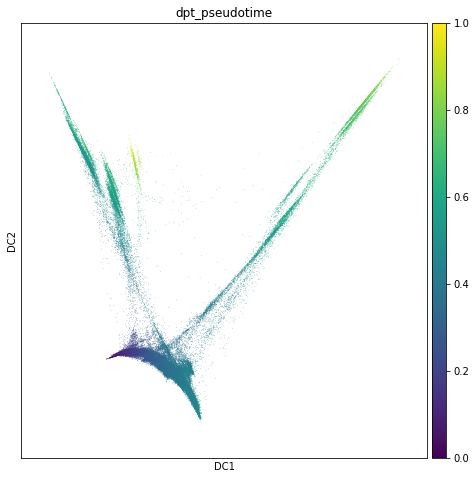

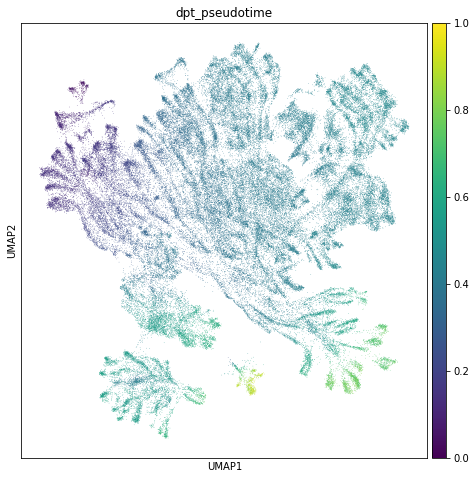

In [70]:
#Visualize pseudotime over differentiation
sc.pl.diffmap(adata, components='1,2', color='dpt_pseudotime')
sc.pl.umap(adata, color=['dpt_pseudotime'], palette=sc.pl.palettes.default_64)

In [72]:
#Separating out the timepoints
e65 = adata[0:1843,:]
e70 = adata[1844:15294,:]
e75 = adata[15295:43528,:]
e80 = adata[43529:67870,:]
e85 = adata[67871:,:]

E7.5    28233
E8.5    24780
E8.0    24342
E7.0    13451
E6.5     1843
Name: stage, dtype: int64


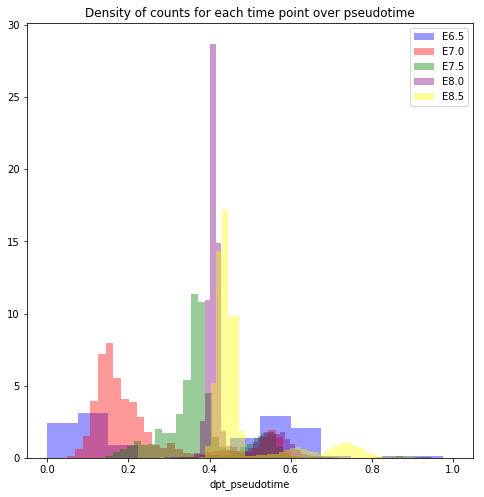

In [73]:
#Plot histogram of no. cells over pseudotime
import scipy.stats
from scipy.stats import norm
print(adata.obs['stage'].value_counts()) #Print no. cells in each time point
p1 = sb.distplot(e65.obs['dpt_pseudotime'], kde=False, color = 'b', norm_hist=True)
p2 = sb.distplot(e70.obs['dpt_pseudotime'], kde=False, color = 'r', norm_hist=True)
p3 = sb.distplot(e75.obs['dpt_pseudotime'], kde=False, color = 'g', norm_hist=True)
p4 = sb.distplot(e80.obs['dpt_pseudotime'], kde=False, color = 'purple', norm_hist=True)
p5 = sb.distplot(e85.obs['dpt_pseudotime'], kde=False, color = 'yellow', norm_hist=True)
plt.title('Density of counts for each time point over pseudotime')
plt.legend(('E6.5', 'E7.0', 'E7.5', 'E8.0', 'E8.5'))
plt.show()

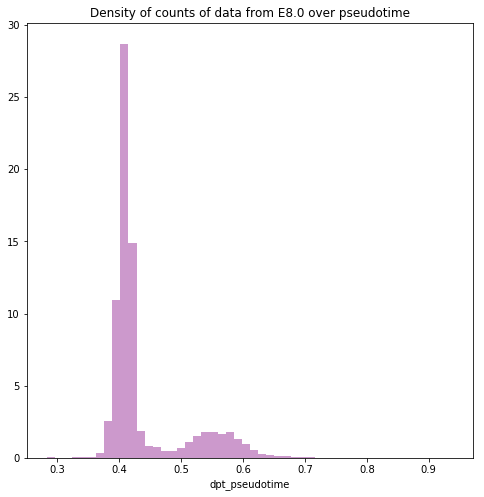

In [78]:
#Looking at an individual plot
p80 = sb.distplot(e80.obs['dpt_pseudotime'], kde=False, color = 'purple', norm_hist=True)
plt.title('Density of counts of data from E8.0 over pseudotime')
plt.show()

## 3.8 Partition-based graph abstraction

running PAGA
    finished (0:00:14)
--> added 'pos', the PAGA positions (adata.uns['paga'])


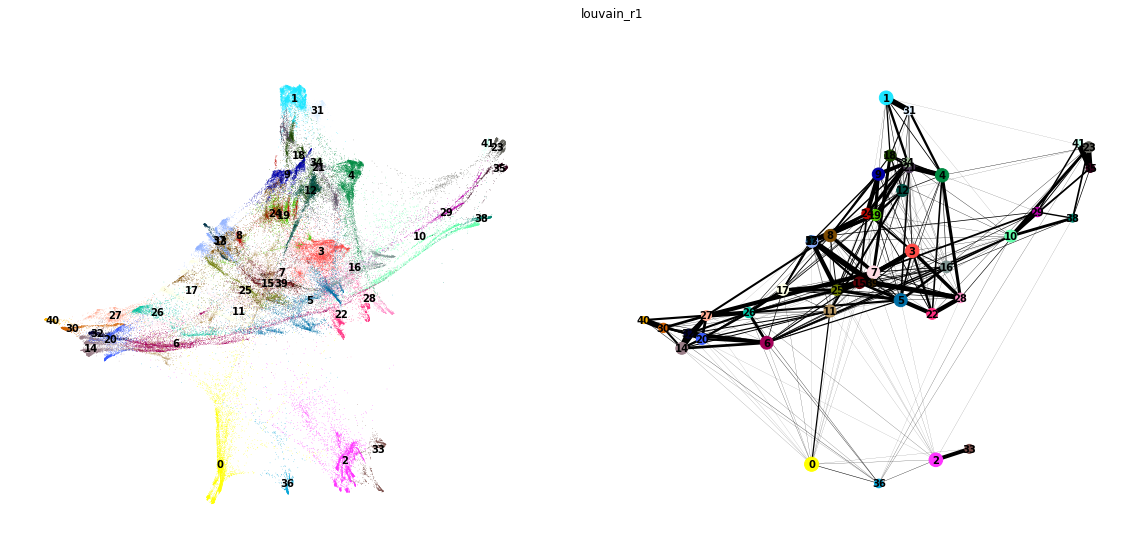

--> added 'pos', the PAGA positions (adata.uns['paga'])


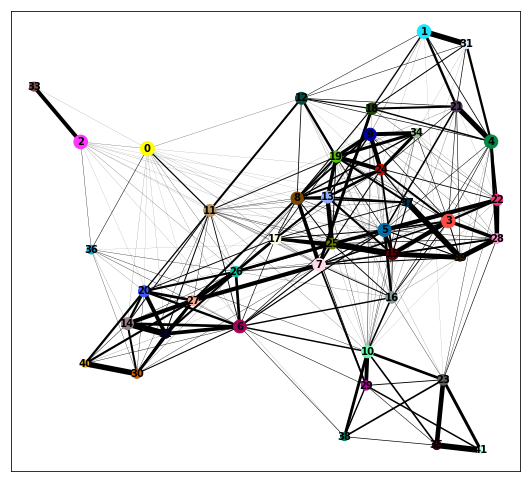

In [52]:
#PAGA
sc.tl.paga(adata, groups='louvain_r1')
sc.pl.paga_compare(adata)
sc.pl.paga(adata)

--> added 'pos', the PAGA positions (adata.uns['paga'])


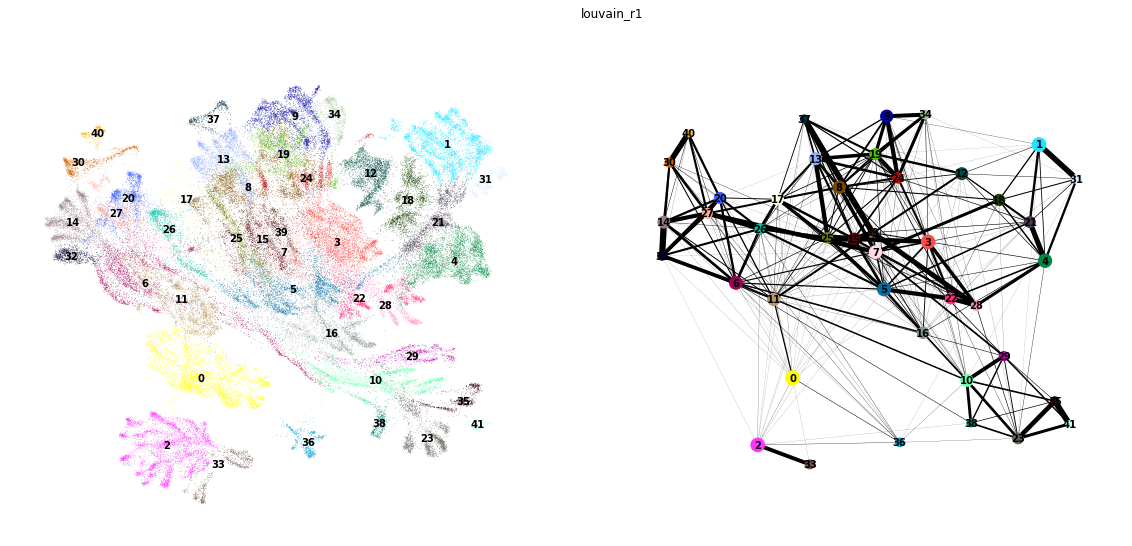

In [53]:
sc.pl.paga_compare(adata, basis='umap')

--> added 'pos', the PAGA positions (adata.uns['paga'])


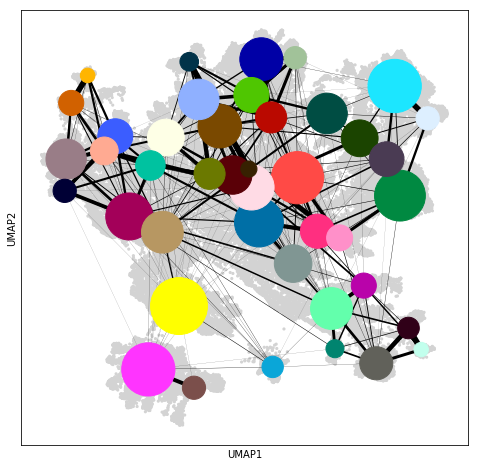

In [54]:
fig1, ax1 = plt.subplots()
sc.pl.umap(adata, size=40, ax=ax1, show=False)
sc.pl.paga(adata, pos=adata.uns['paga']['pos'], show=False, node_size_scale=10, node_size_power=1, ax=ax1, text_kwds={'alpha':0})
#plt.savefig('./figures/umap_paga_overlay_gut.pdf', dpi=300, format='pdf')
plt.show()